# Human Activity Recognition  - Capstone Project (2/2)

This is the second notebook that focuses on the final approach to this capstone. I have decided to trim the dataset to 10 classes to reduce model complexity and computational load. Again, I will breaking the videos into frames and batch feeding image arrays into a 2D convolutional neural network. 

### Loading in the Data

The dataset provided text files with some basic information about the videos and the respective indexes. Lets read in the data and see what we are working with. 

In [748]:
# import libaries 
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import os 
import cv2
import math 
from glob import glob
from tqdm import tqdm

Reading in the `classInd.txt` is very important because it shows us all the class names and respective class index from the Dataset. 

In [1077]:
# read in `classInd.txt` - contains class name and index name
f = open('C://Users//jzqma//Documents//CapstoneProject//Capstone_Project_Transfer_Model//data//classInd.txt', 'r')
temp = f.read()

# split on line space 
video_category = temp.split('\n')

# creating a dataframe containing the classInds 
class_ind = pd.DataFrame()
class_ind['Video Category'] = video_category

# removes empty row at row index 101 
class_ind = class_ind[:-1]


# remove number in front of each value in Video Category column 
#create empty lists
new_values = []
class_index =[]

# loop though each value in each row 
for value in class_ind['Video Category']:
    
    # split the value by empty space and append the second portion to new_values list
    new_values.append(value.split()[1])
    
    # split the value by empty space and append the first portion to class_index list
    class_index.append(value.split()[0])

#create new columns 
class_ind['Video Category'] = new_values
class_ind['Class Index'] = class_index

# check
print('New "class_ind" dataframe')
class_ind

New "class_ind" dataframe


,Video Category,Class Index
0,ApplyEyeMakeup,1
1,ApplyLipstick,2
2,Archery,3
3,BabyCrawling,4
4,BalanceBeam,5
...,...,...
96,VolleyballSpiking,97
97,WalkingWithDog,98
98,WallPushups,99
99,WritingOnBoard,100


Reading in `trainlist01.txt` and `testlist01.txt` is crucial as they contain the list all the video names from the Dataset. We need this information when performing EDA and preprocessing on the data. 

In [1078]:
# read in the `trainlist01.txt` - contains TRAIN SET video names 
f = open('C://Users//jzqma//Documents//CapstoneProject//Capstone_Project_Transfer_Model//data//trainlist01.txt', 'r')
temp = f.read()
videos = temp.split('\n')

# create a dataframe containing video names 
train = pd.DataFrame()
train['video_name'] = videos
train = train[:-1] 

# converting the dataframe into csv file 
train.to_csv('trainlist01.csv',header=True, index=False)

# check
print('"train" dataframe - contains TRAIN SET video names')
train.head()

"train" dataframe - contains TRAIN SET video names 


,video_name
0,ApplyEyeMakeup/v_ApplyEyeMakeup_g08_c01.avi 1
1,ApplyEyeMakeup/v_ApplyEyeMakeup_g08_c02.avi 1
2,ApplyEyeMakeup/v_ApplyEyeMakeup_g08_c03.avi 1
3,ApplyEyeMakeup/v_ApplyEyeMakeup_g08_c04.avi 1
4,ApplyEyeMakeup/v_ApplyEyeMakeup_g08_c05.avi 1


In [1079]:
# repeat steps for `testlist01.txt` - contains TEST SET video names 
# open the .txt file which have names of test videos
f = open('C://Users//jzqma//Documents//CapstoneProject//Capstone_Project_Transfer_Model//data//testlist01.txt', 'r')
temp = f.read()
videos = temp.split('\n')

# creating a dataframe having video names
test = pd.DataFrame()
test['video_name'] = videos
test = test[:-1]

# check
print('"test" dataframe - contains TEST SET video names')
test.head()

"test" dataframe - contains TEST SET video names


,video_name
0,ApplyEyeMakeup/v_ApplyEyeMakeup_g01_c01.avi
1,ApplyEyeMakeup/v_ApplyEyeMakeup_g01_c02.avi
2,ApplyEyeMakeup/v_ApplyEyeMakeup_g01_c03.avi
3,ApplyEyeMakeup/v_ApplyEyeMakeup_g01_c04.avi
4,ApplyEyeMakeup/v_ApplyEyeMakeup_g01_c05.avi


### Exploratory Data Analysis and Preprocessing

**NOTE** - To Educators, ensure to empty the data directory but leave the text files and `saved_models` folder if you want to check the function below. Be sure to create a `train` and `test` folder inside the `data` directory.

The original database provided a directory, called `UCF101`, of all the videos and split by category folder. However, all the videos are **not** split by TRAIN SET or TEST SET. I have written a function to convert videos, based on SET, to frames and transfer the frames to a frames folder. 

I created an infographic to explain the general steps of the preprocessing.

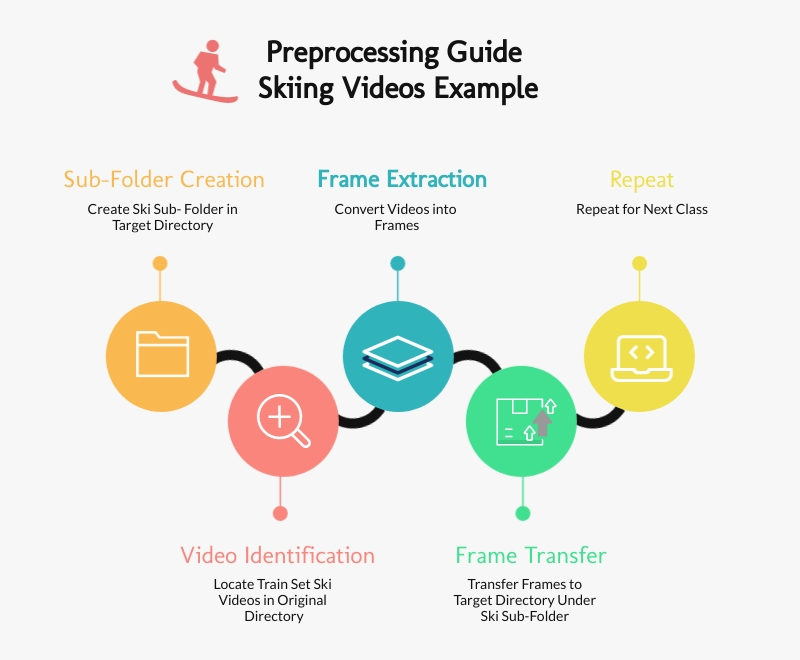

In [56]:
# Make SET folder in the data folder and category folders in SET folder

def videos_to_frames_transferfolder(index, set_name, folder):
    
    '''
    This function contains 5 steps:
    
        Lets use the Skiing Class and TRAIN SET as an example
        
        Sub-Folder Creation – Create Ski Sub-Folder in Target Directory 
        Video Identification – Locate TRAIN SET Ski Videos in Original Directory (UCF101)
        Frame Extraction – Convert Videos into Frames 
        Frame Transfer – Transfer Frames to Target Directory Under Ski Sub-Folder
        Repeat – Repeat for Next Class in the given class labels dataframe 
        
    The function requires three arguments: index, set_name, folder 
        
        index (non-string) - the dataframe that contain the class labels 
        set_name (non-string) - train or test or validation
        folder (string) - folder name to create 
    
    Example: 
        
        videos_to_frames_transferfolder(reduced_class_ind, train, 'train_10')

    '''

    # loop through each element in given class label dataframe
    for element in index['Video Category']:
    
        #make category folders for SET
        path = 'C:\\Users\\jzqma\\Documents\\CapstoneProject\\Capstone_Project_Transfer_Model\\data\\' + folder + '\\' + element
    
        # command to create folder to the path provided
        os.mkdir(path)
    
        # storing the frames from each category X video in the new category folder
        # create a frame counter but gets resetted back to 0 for each element 
        count = 0 
        
        # loop through each row in SET dataframe 
        for i in range(len(set_name['video_name'])):
            
            # if the splitted video name is equal to element
            if set_name['video_name'][i].split('/')[0] == element: 
            
                #create videoFile variable to store video name 
                videoFile = set_name['video_name'][i]
                
                # use cv2 library to capture the video
                cap = cv2.VideoCapture('UCF101/'+ element + '/' +videoFile.split(' ')[0].split('/')[1])
                
                # set the frame rate to 5, so we get 5 frames per second of the video
                frameRate = cap.get(5)
                
                # the code below I had some learned and took influences from a stackover posting
                x=1
                
                # while this condition is True -> cap.isOpened() is True means that the video capture by cv2 was successful
                while(cap.isOpened()):
                    
                    # frameID variable stores current frame number
                    frameId = cap.get(1) 
                    
                    # read the video capture 
                    ret, frame = cap.read()
                    if (ret != True):
                        break
                    
                    # ensures the we within the number of total frames 
                    if (frameId % math.floor(frameRate) == 0):
                        
                        # path to store the frame 
                        filename = 'data/' + folder + '/' + element + '/' + videoFile.split('/')[1].split(' ')[0] + "_frame%d.jpg" % count;count+=1
                        
                        # command to transfer the frame to the given path
                        cv2.imwrite(filename, frame)
                        
                # resets the video capture
                cap.release()

In [ ]:
# Create 101 category folders for train and test set 

#videos_to_frames_transferfolder(class_ind, train, 'train')
#videos_to_frames_transferfolder(class_ind, test, 'test')

### Check Class Balance 

Lets check the class balance for TRAIN and TEST set. 

We can see from the graph below there is significant class imbalance between the 101 classes. I want to lower the complexity of the model and computational load. To achieve this, I will reduced the total classes to 10. I will pick 10 classes have similar class balances. 

In [754]:
class_ind.sort_values(by='Num of Frames TRAIN')   261 - 1746

,Video Category,Class Index,Num of Frames TRAIN
71,PushUps,72,261
46,JumpingJack,47,299
8,BasketballDunk,9,352
13,BlowingCandles,14,356
69,PullUps,70,364
...,...,...,...
26,Drumming,27,1377
70,Punch,71,1387
73,RockClimbingIndoor,74,1543
47,JumpRope,48,1668


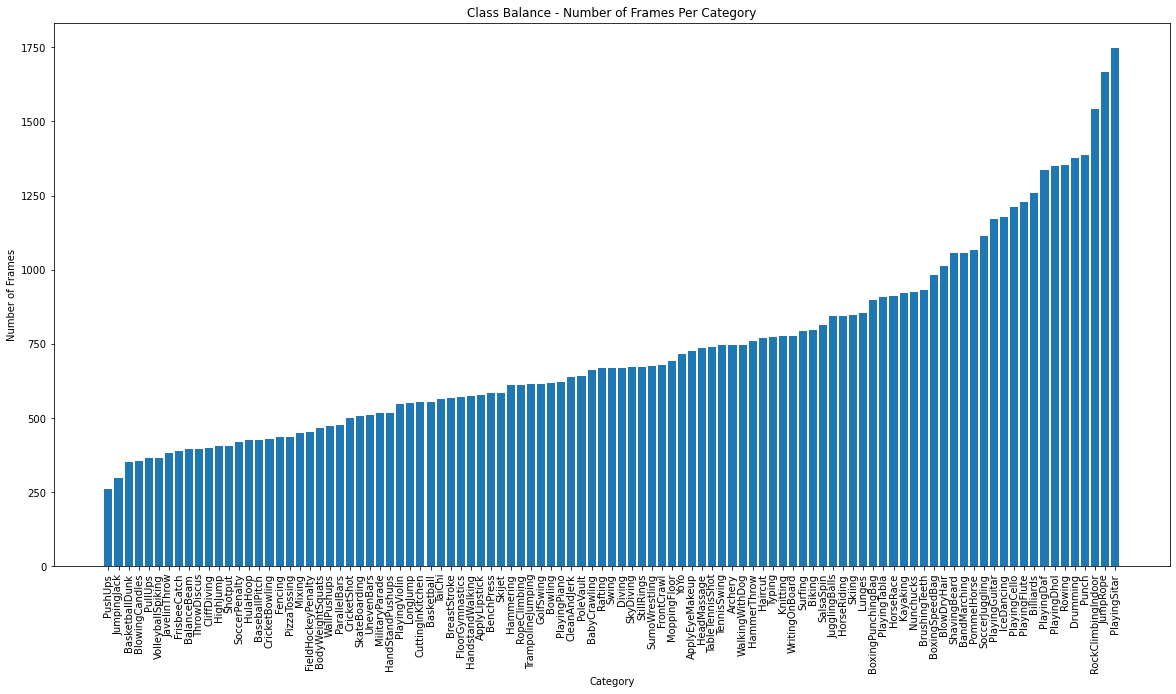

In [1081]:
# get number of frames per category folder - TRAIN FOLDER
# plot the class balance

import os.path

category_list = class_ind['Video Category']

num_files_list = []

# loop through category_list
for category in category_list: 

    # get path
    path = os.getenv('HOME') + '/Documents/CapstoneProject/Capstone_Project_Transfer_Model/data/train/' + category
    
    # get number of files count number of files - I read a Stackoverflow post for influences - https://stackoverflow.com/questions/2632205/how-to-count-the-number-of-files-in-a-directory-using-python
    num_files = len([file for file in os.listdir(path) if os.path.isfile(os.path.join(path, file))])
    
    # append num_files to num_files_list
    num_files_list.append(num_files)
    
class_ind['Num of Frames TRAIN'] = num_files_list


# plot class balances

# sort by Num of Frames TRAIN
class_balance = class_ind[['Video Category', 'Num of Frames TRAIN']].sort_values(by='Num of Frames TRAIN')

# set the x_axis and y_axis variables 
x_axis = class_balance['Video Category']
y_axis = class_balance['Num of Frames TRAIN']

plt.figure(figsize=[20,10])
plt.bar(x_axis, y_axis)

# labels
plt.title('Class Balance - Number of Frames Per Category')
plt.xlabel('Category')
plt.ylabel('Number of Frames')
plt.xticks(rotation=90)
plt.show()

In [1082]:
# get number of frames per category folder - test FOLDER
import os.path

category_list = class_ind['Video Category']

num_files_list_test = []

for category in category_list: 

    path = os.getenv('HOME') + '/Documents/CapstoneProject/Capstone_Project_Transfer_Model/data/test/' + category
    
    num_files = len([file for file in os.listdir(path) if os.path.isfile(os.path.join(path, file))])
    
    num_files_list_test.append(num_files)
    
class_ind['Num of Frames TEST'] = num_files_list_test

In [1083]:
# Get % Frames TRAIN + TEST 

total_frames = sum(num_files_list)

percentage_frames_outa_total_train = []

for frames in num_files_list:
    
    percentage_frames_outa_total_train.append(round((frames / total_frames) * 100,2))

class_ind['frames/total TRAIN %'] = percentage_frames_outa_total_train


total_frames = sum(num_files_list_test)

percentage_frames_outa_total_test = []

for frames in num_files_list_test:
    
    percentage_frames_outa_total_test.append(round((frames / total_frames) * 100,2))

class_ind['frames/total TEST %'] = percentage_frames_outa_total_test

Lets reset the index and sort `class_ind` by `Num of Frames TRAIN` and look at the bottom 30 rows.  

In [1084]:
class_ind.sort_values(by='frames/total TRAIN %').reset_index(drop=True).tail(30)

,Video Category,Class Index,Num of Frames TRAIN,Num of Frames TEST,frames/total TRAIN %,frames/total TEST %
71,SalsaSpin,77,813,398,1.10,1.38
72,HorseRiding,42,844,333,1.14,1.15
73,JugglingBalls,46,843,423,1.14,1.46
74,Skiing,81,848,377,1.15,1.30
75,Lunges,52,855,372,1.16,1.29
76,BoxingPunchingBag,17,899,428,1.22,1.48
77,HorseRace,41,910,246,1.23,0.85
78,PlayingTabla,66,909,351,1.23,1.21
79,Nunchucks,56,925,367,1.25,1.27
80,Kayaking,49,922,283,1.25,0.98


After some EDA, I found that index rows 72 to 81 have relatively even class balance for the TRAIN/TEST folder. I will reduced the dataset to those categories. 

In [1085]:
# create new class label dataframe 
reduced_class_ind = class_ind.sort_values(by='frames/total TRAIN %').reset_index(drop=True).iloc[72:82]

# lets remove the percentages and reset the index 
reduced_class_ind = reduced_class_ind[['Video Category', 'Class Index', 'Num of Frames TRAIN', 'Num of Frames TEST']].reset_index(drop=True)

# check
print('new class label dataframe - "reduced_class_ind"')
reduced_class_ind

new class label dataframe - "reduced_class_ind"


,Video Category,Class Index,Num of Frames TRAIN,Num of Frames TEST
0,HorseRiding,42,844,333
1,JugglingBalls,46,843,423
2,Skiing,81,848,377
3,Lunges,52,855,372
4,BoxingPunchingBag,17,899,428
5,HorseRace,41,910,246
6,PlayingTabla,66,909,351
7,Nunchucks,56,925,367
8,Kayaking,49,922,283
9,BrushingTeeth,20,931,450


In [23]:
# create plot class balance function 

def plot_class_balance(df, x_axis_column, y_axis_column):
    
    '''
    This function plots class balances and requires 3 arguments: df, x_axis_column, y_axis_column.
    
    df (non-string) - name of dataframe 
    x_axis_column (string) - name of the column in dataframe for the X axis 
    y_axis_column (string) - name of the column in dataframe for the Y axis 
    
    Example: 
    plot_class_balance(reduced_class_ind, 'Video Category', 'Num of Frames TRAIN')
    '''
    
    title = '- '+ y_axis_column.split('s ')[1] + ' Set'
    
    plt.figure(figsize=[20,10])
    plt.bar(df[x_axis_column], df[y_axis_column])
    
    # labels 
    plt.title('Class Balance - Number of Frames Per Category' + title )
    plt.xlabel('Category')
    plt.ylabel('Number of Frames')
    plt.xticks(rotation=90)

plt.show()

As we can see from the graphs below, the chosen 10 categories are evenly balanced.

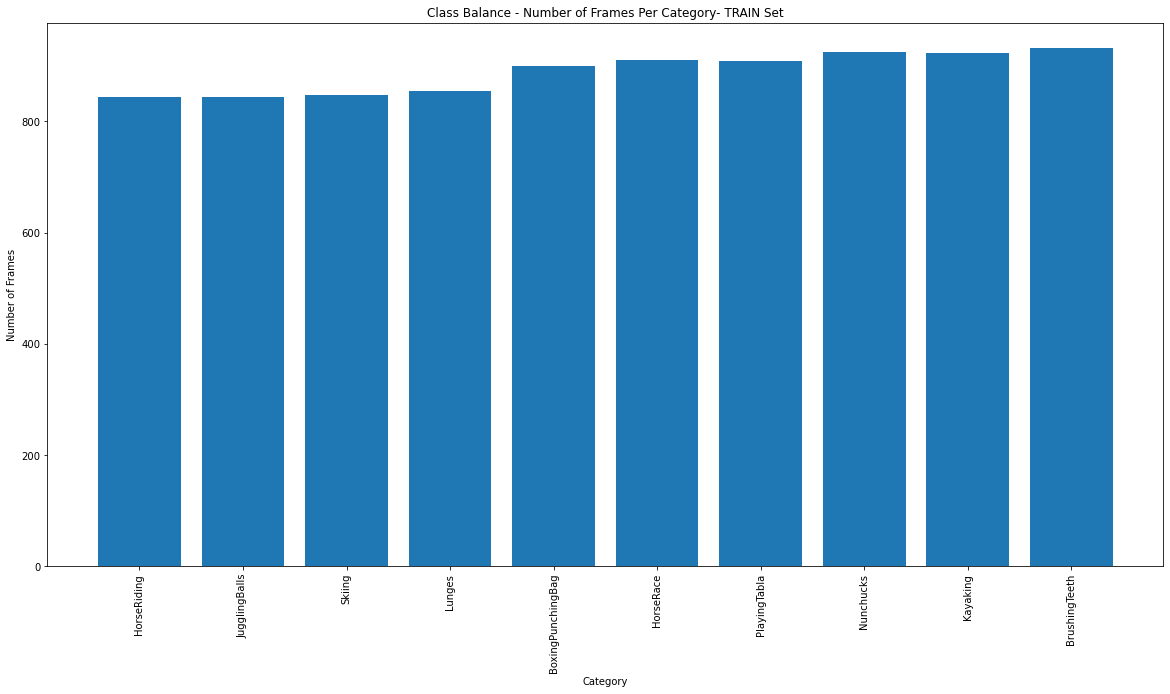

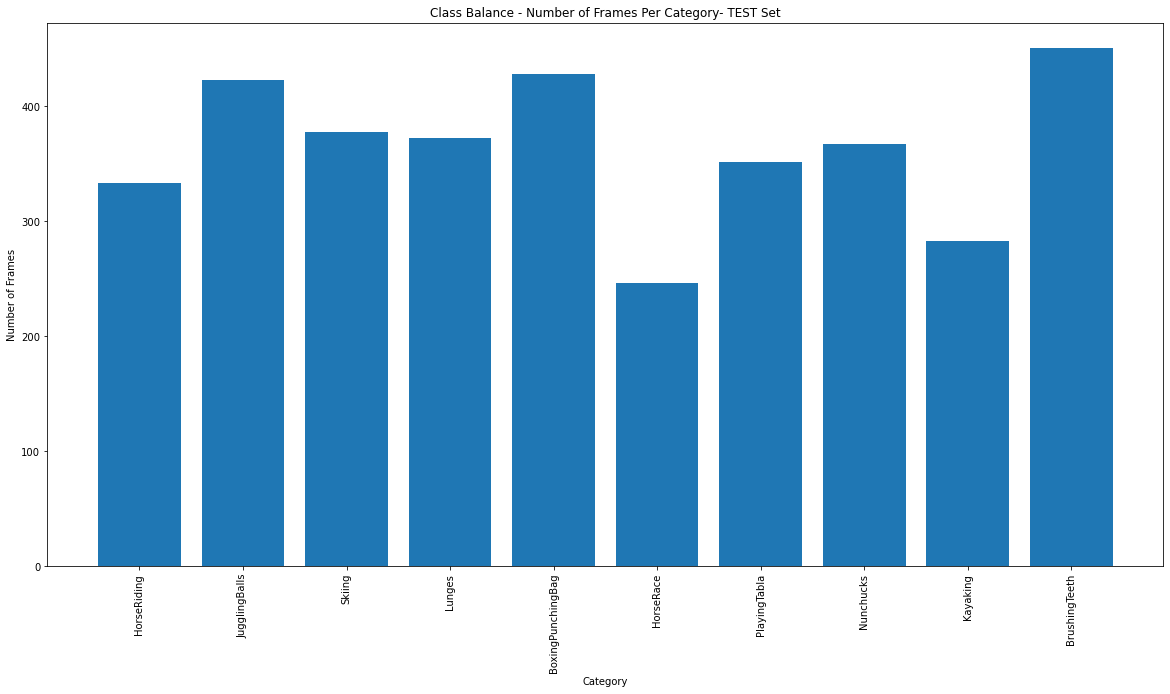

In [24]:
# Plot New Class Balances
plot_class_balance(reduced_class_ind, 'Video Category', 'Num of Frames TRAIN')
plot_class_balance(reduced_class_ind, 'Video Category', 'Num of Frames TEST')

I will need to manually create new train and test folders called `train_10` and `test_10` in the `data` directory. Next, I will use my `videos_to_frames_transferfolder` function to get the appropriate frames to the new `train_10` and `test_10` folder.

In [102]:
# videos to frames -> transfer to respective folder 
videos_to_frames_transferfolder(reduced_class_ind, train, 'train_10')
videos_to_frames_transferfolder(reduced_class_ind, test, 'validation_10')

### Creating Validation Set

I want to make dataframe of all names of the frames and their respective category. This will be the first step in creating a validation set. 

In [130]:
# create dataframe of all names of frames 

# create class range 
class_range = reduced_class_ind['Video Category']

# create empty list for frame names and class names 
train_frames = []
train_class = [] 

# loop through each class
for video_category in class_range:
    
    # clear variable
    frames = None
    
    # collect all the path names of each frame in the video_category folder 
    frames = glob('data/train_10/' + video_category + '/*.jpg')
    
    # loop through each path 
    for i in range(len(frames)):
        
        # get frame name and append to train_frames 
        train_frames.append(frames[i].split('\\')[1])
        
        # get class name and append to train_class
        train_class.append(frames[i].split('_g')[0].split('v_')[1])
        
# storing the frame names and their class in a dataframe
train_frames_data = pd.DataFrame()
train_frames_data['frame name'] = train_frames
train_frames_data['class'] = train_class

# check
print('"train_frames_data" - dataframe')
train_frames_data.head()

,frame name,class
0,v_HorseRiding_g08_c01.avi_frame0.jpg,HorseRiding
1,v_HorseRiding_g08_c01.avi_frame1.jpg,HorseRiding
2,v_HorseRiding_g08_c01.avi_frame2.jpg,HorseRiding
3,v_HorseRiding_g08_c01.avi_frame3.jpg,HorseRiding
4,v_HorseRiding_g08_c01.avi_frame4.jpg,HorseRiding


First, we create a `validation_10` folder in our `data` folder. We will create a dataframe for frame names for the validation set.

In [131]:
import os 
import shutil

# Make Class Folders for the Validation_10 Folder 
# loop through each element in class_ind
class_range = reduced_class_ind['Video Category']

# loop through each element in class_range
for element in class_range:
    
    #make category folders for validation set
    path = 'C:\\Users\\jzqma\\Documents\\CapstoneProject\\Capstone_Project_Transfer_Model\\data\\validation_10\\' + element
    
    # command to create folder to the path provided
    os.mkdir(path)

    
# Transfer Frames from the Train_10 Folder to the Validation_10 Folder  
# create frames name list  
frame_names_list = train_frames_data['frame name']

# loop through each video category
for video_category in class_range:
    
    # Create empty frames counter. This will hold all the frames for the respective category but it will reset
    # after each loop
    frames_counter = []
    
    # loop through each frame name in list 
    for frame_name in frame_names_list:
        
        # check if the video_category matches the frame name category tag
        if video_category == frame_name.split('_g')[0].split('_')[1]:
            
            # append frame_name to frames_counter 
            frames_counter.append(frame_name)
            
    # find out how many frames to transfer to validation set, we will set 20% of train data. We need to round the 
    # result as it might not be a whole number. We also need to mutiple by -1 to transfer the frames starting from the tail
    # of frames_counter 
    numframes_to_validation = round(len(frames_counter) * 0.2) * -1 
    frames_counter = frames_counter[numframes_to_validation::1]
    
    # move frames to validation folder 
    # loop through the indexes of frames_counter
    for i in range(len(frames_counter)):
            
        # path of frame
        original = 'C:\\Users\\jzqma\\Documents\\CapstoneProject\\Capstone_Project_Transfer_Model\\data\\train_10\\' + video_category + "\\" + frames_counter[i]
            
        # target path of frame
        target = 'C:\\Users\\jzqma\\Documents\\CapstoneProject\\Capstone_Project_Transfer_Model\\data\\validation_10\\' + video_category + "\\" + frames_counter[i]
            
        # command to activate transfer
        shutil.move(original, target)

## Creating ImageDataGenerator 

The `ImageDataGenerator` has lots of parameters that are useful in supporting the completion of this capstone project. As stated in `The Journey` notebook, the training time per epoch was taking about 1 hour per epoch on my personal computer. I will reduce the image dimension by a magnitude of 100 to reduce the computation load and increase epoch training speed. The new changes will be from 240x320 to 24x32. I will also set the color channel to 1. I want to prevent the neural network picking up color as a feature because I want to focus on human activity. Therefore, the new frame dimensions are 24x32x1.

The pixel values on our frames range of 0-255. I will rescale the pixel values to fall between 0 and 1 before passing the values in the CNN. Furthermore, I will perform Data Augmentation to TRAIN SET. I confirmed on [StackOverflow](https://stackoverflow.com/questions/48029542/data-augmentation-in-test-validation-set) that Data Augmentation is only performed on the trainning data. 

There are 3 transformations I will performing on the TRAIN SET. The first transformation is rotation. I want slightly rotate my image. In real life, human actions can be performed in many rotation angles so I think a reasonable range to be set at 30 degrees. Zoom will be another transformation. I think a 20% zoom is reasonable as this way one can still identify the image.  For example, a person can run farther into the distance. This will be useful for the CNN to learn. The last transformation is vertical flip. Human actions can be performed from both sides. This will critical for the CNN to learn.

The color mode will be set to grayscale. As stated before, I want to prevent the neural network to pick up color as a feature because I want to focus on human activity. The class mode is set to categorical because we have 10 class classification problem. 

Lastly, I will batch my frames in 32's. 32 is a good starting number to test batch sizes. If my epoch training speed is slow, I can edit my batch size. The `test_generator` will have a batch size of 3630 because we don't want to batch the data when we are doing model evaluations. This will allow the `test_generator` to pass all the frames at once. 

In [674]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from numpy.random import seed

In [675]:
# setting seed 
seed(1)

In [1087]:
# creating image data generator for "image visualize"

# Reduce frame dimensions by 20%.
height = 192 
width = 256
channels = 1

# Create training image data generator.
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=30,
                                   zoom_range=0.2,
                                   vertical_flip=True)

# Create validation image data generator.
# Only apply rescaling to our validation data.
validation_datagen = ImageDataGenerator(rescale=1./255)

# Create test image data generator.
# Only apply rescaling to our test data
test_datagen = ImageDataGenerator(rescale=1./255)

# Finaly we specify where the images should be loaded from
# as well as some additional attributes:
train_generator=train_datagen.flow_from_directory('data/train_10',
                                                 target_size=(height,width),
                                                 color_mode='grayscale',
                                                 batch_size=32,
                                                 class_mode='categorical')

validation_generator=validation_datagen.flow_from_directory('data/validation_10',
                                                 target_size=(height,width),
                                                 color_mode='grayscale',
                                                 batch_size=32,
                                                 class_mode='categorical')

test_generator = test_datagen.flow_from_directory('data/test_10',
                                                  target_size=(height,width),
                                                  color_mode='grayscale',
                                                  batch_size=3630,
                                                  class_mode='categorical')

X_test, y_test = test_generator.next()

Found 7108 images belonging to 10 classes.
Found 1778 images belonging to 10 classes.
Found 3630 images belonging to 10 classes.


The summarize the results from above, the `ImageDataGenerator` found:

* 7108 images (frames) for the TRAIN SET
* 1778 images (frames for the Validation SET
* 3630 images (frames) for the TEST SET

### Visualize Images

Here are the 10 classes and an example frame. 

In [846]:
# creating category_names to help visualize the images 
category_names = reduced_class_ind['Video Category'].tolist()
category_names.sort()
category_names

['BoxingPunchingBag',
 'BrushingTeeth',
 'HorseRace',
 'HorseRiding',
 'JugglingBalls',
 'Kayaking',
 'Lunges',
 'Nunchucks',
 'PlayingTabla',
 'Skiing']

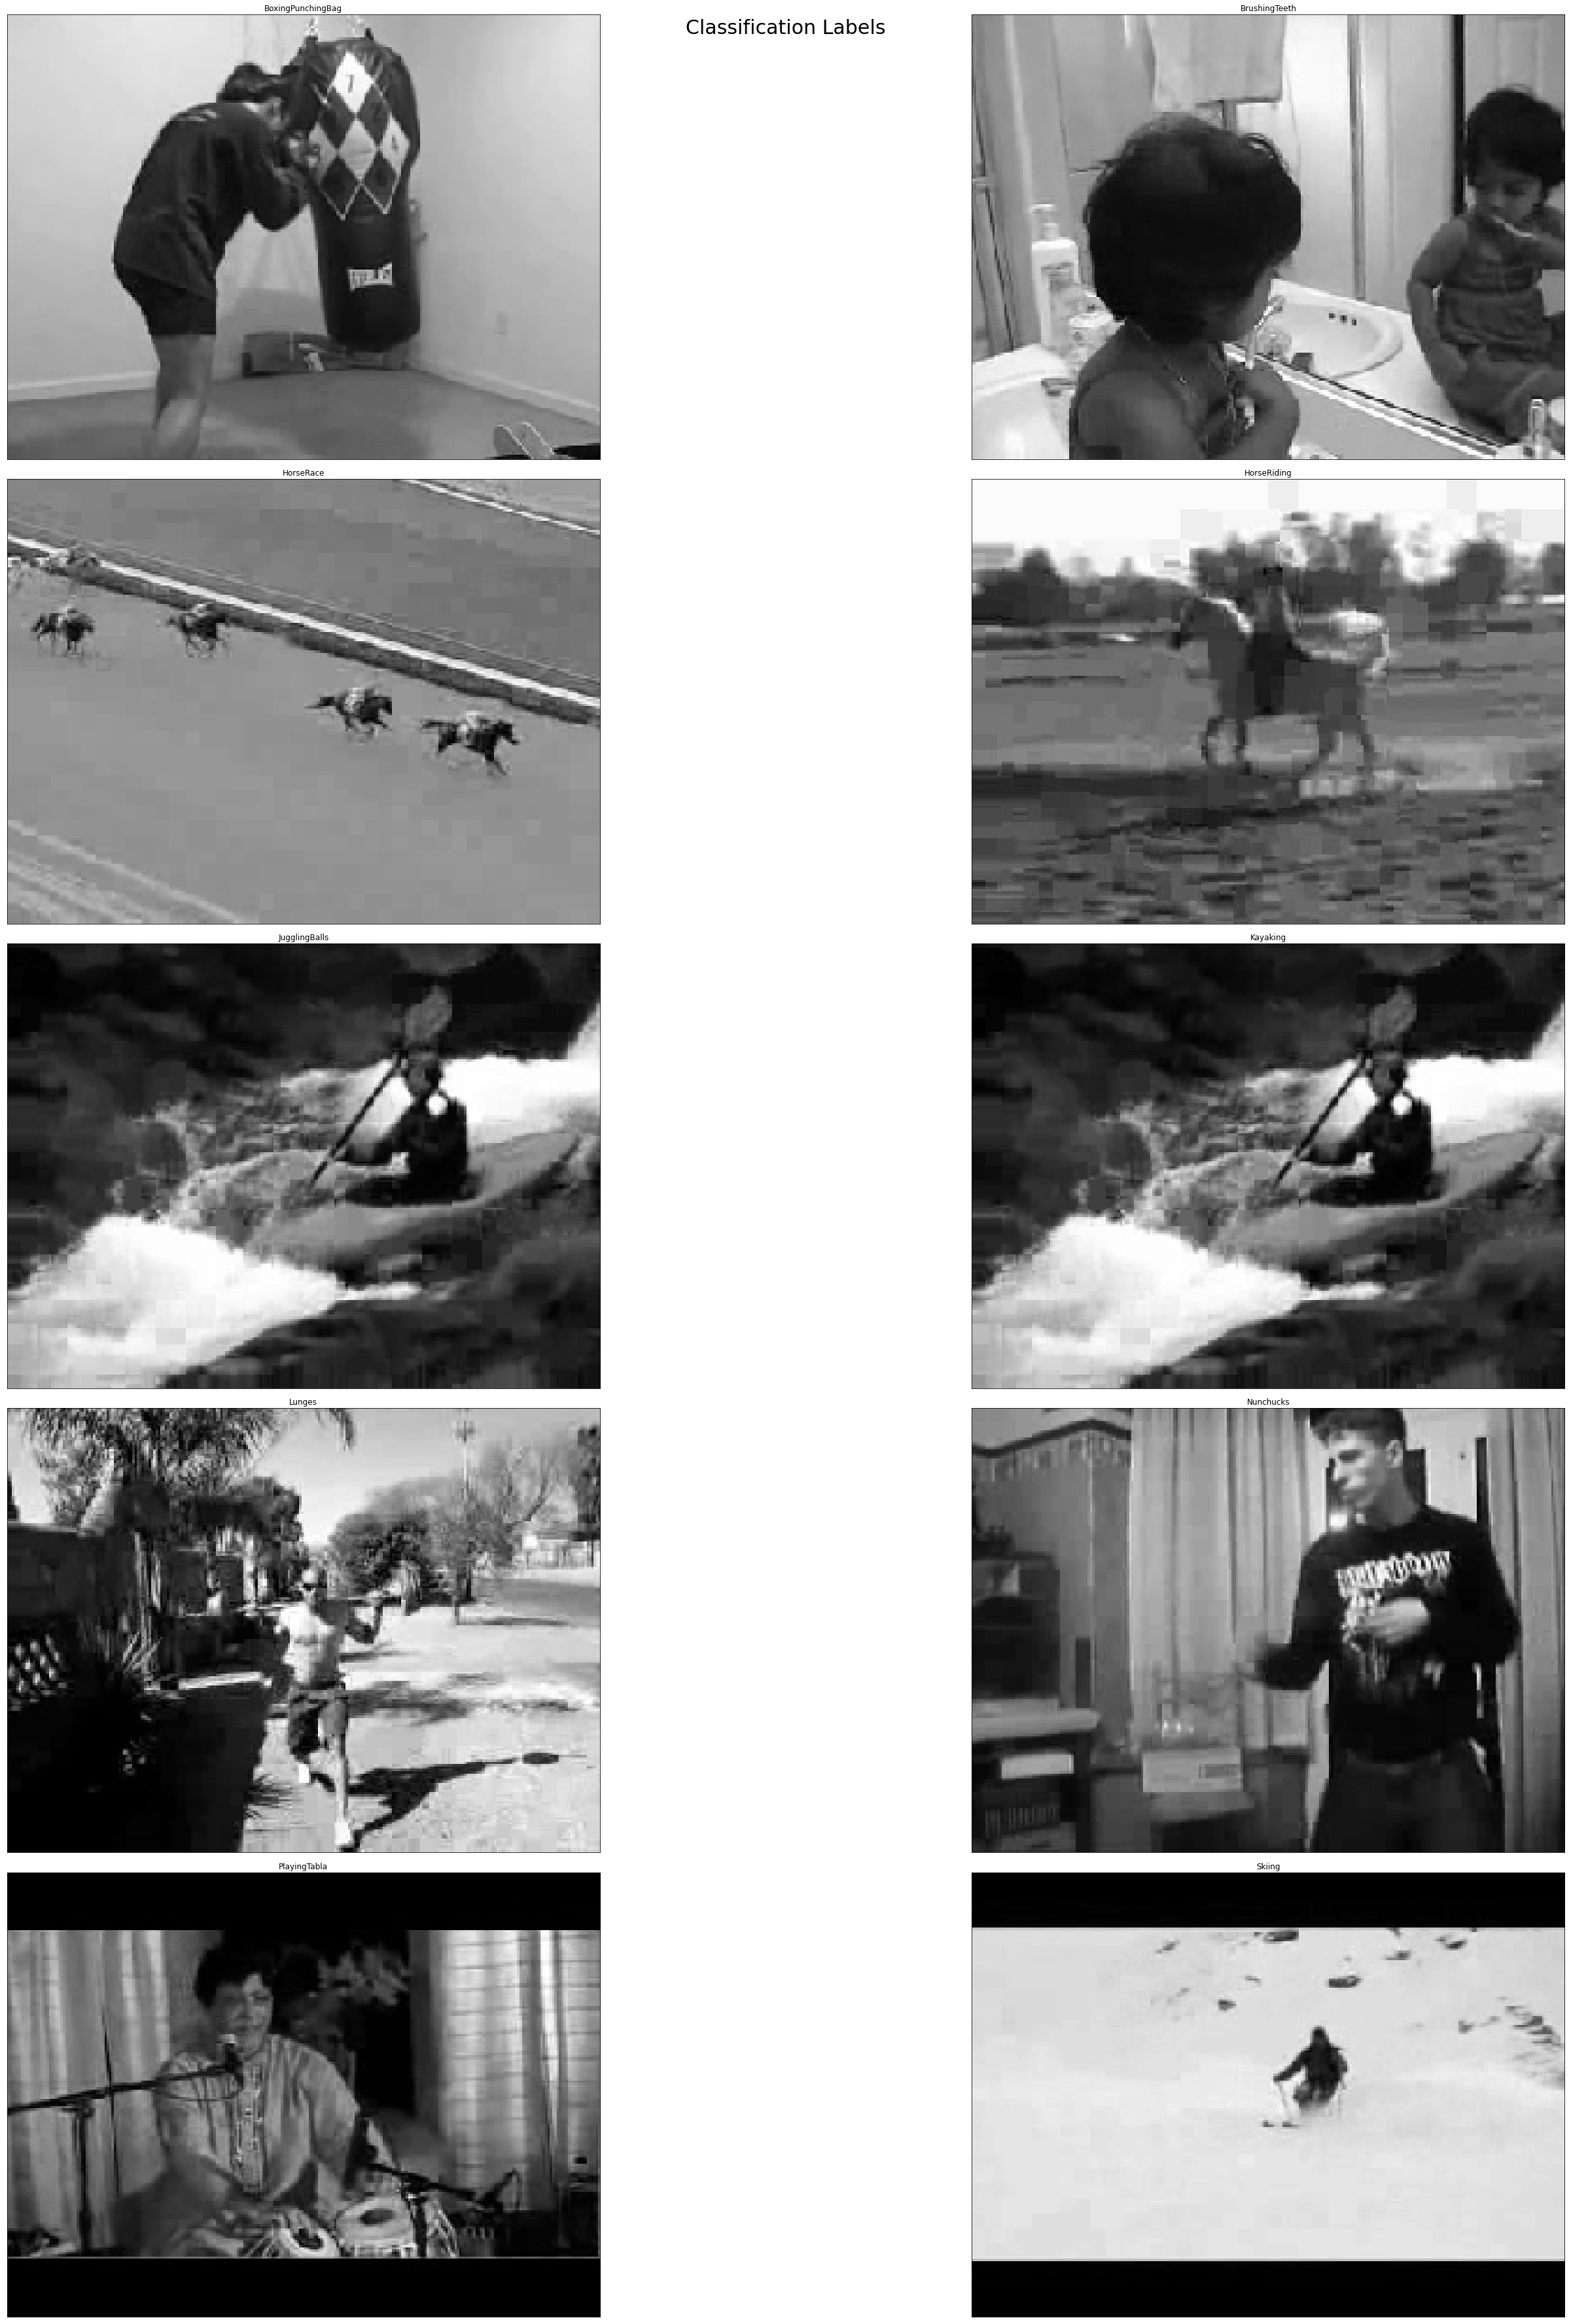

In [1090]:
# # Grab a batch of images from our validation generator: 
x, y = validation_generator.next() 

# Our images labels are one-hot encoded, lets 
# convert them to ordinal encoding
labels = np.argmax(y, axis=1)

fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(50, 50))
ax = ax.flatten()

for i in np.arange(0,10):
    index = np.argmax(labels==i) 
    ax[i].imshow(x[index], cmap='gray')
    
    
    # Set the title of the subplot
    ax[i].set_title(category_names[i])
    
    # Hide the x and y ticks
    ax[i].set_xticks([]) 
    ax[i].set_yticks([])
    

fig.suptitle("Classification Labels", size = 30)
fig.tight_layout()

In [1091]:
# creating image data generator for CNN
# I am reducing dimensions for computation speed
height = 24 
width = 32
channels = 1

# Create training image data generator.
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=30,
                                   zoom_range=0.2,
                                   vertical_flip=True)

# Create validation image data generator.
# Only apply rescaling to our validation data.
validation_datagen = ImageDataGenerator(rescale=1./255)

# Create test image data generator.
# Only apply rescaling to our test data
test_datagen = ImageDataGenerator(rescale=1./255)

# Finaly we specify where the images should be loaded from
# as well as some additional attributes:
train_generator=train_datagen.flow_from_directory('data/train_10',
                                                 target_size=(height,width),
                                                 color_mode='grayscale',
                                                 batch_size=32,
                                                 class_mode='categorical')

validation_generator=validation_datagen.flow_from_directory('data/validation_10',
                                                 target_size=(height,width),
                                                 color_mode='grayscale',
                                                 batch_size=32,
                                                 class_mode='categorical')

test_generator = test_datagen.flow_from_directory('data/test_10',
                                                  target_size=(height,width),
                                                  color_mode='grayscale',
                                                  batch_size=3630,
                                                  class_mode='categorical')

X_test, y_test = test_generator.next()

Found 7108 images belonging to 10 classes.
Found 1778 images belonging to 10 classes.
Found 3630 images belonging to 10 classes.


### Modelling 

**CNN Network - Naive Model** 

I will build a simple 2D convolutional neural network architecture. The first model will be called the `Naive Model`. I will use a `ReLu` activation function for the input and hidden layers. Since we have a 10 class classification problem, I will use a `Softmax` activation function for the output layer. I will also add `dropout` layer followed by `batch normalization` layer to help with overfitting. I confirmed this ordering by [StackOverFlow.](https://stackoverflow.com/questions/39691902/ordering-of-batch-normalization-and-dropout) Finally, I will use `Adam` optimizer  to begin and use a `categorical crossentropy` loss function. 

In [784]:
# import libaries 
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Dropout, Flatten, Conv2D
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping

In [785]:
naive_model  = Sequential()

# Create simple CNN model architecture with Pooling for dimensionality reduction 
# and Dropout to reduce overfitting
naive_model.add(Conv2D(64, kernel_size=(3, 3), activation = 'relu', input_shape = (24, 32, 1)))
naive_model.add(MaxPooling2D(pool_size=(2, 2)))
naive_model.add(Dropout(0.25))                     
naive_model.add(BatchNormalization()) 

naive_model.add(Conv2D(128, (3, 3), activation='relu'))
naive_model.add(MaxPooling2D(pool_size=(2, 2)))
naive_model.add(Dropout(0.25))
naive_model.add(BatchNormalization()) 

naive_model.add(Conv2D(128, (3, 3), activation='relu'))
naive_model.add(MaxPooling2D(pool_size=(2, 2)))
naive_model.add(Dropout(0.25))
naive_model.add(BatchNormalization()) 

# Flatten the output of our convolutional layers           
naive_model.add(Flatten())

# Add dense layers
naive_model.add(Dense(64, activation='relu'))
naive_model.add(Dense(32, activation='relu'))
naive_model.add(Dense(10, activation='softmax'))

# Print out a summary of the network
CNN_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 22, 30, 64)        640       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 11, 15, 64)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 11, 15, 64)        0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 11, 15, 64)        256       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 9, 13, 128)        73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 4, 6, 128)         0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 4, 6, 128)        

In [786]:
# Compile the model with the desired loss function, optimizer, and metric(s) to track
naive_model.compile(loss = 'categorical_crossentropy',
                  optimizer = 'Adam',
                  metrics = ['accuracy'])

In [787]:
naive_model.fit(train_generator,
              epochs=100,
              validation_data = validation_generator,
              )

Epoch 1/100
223/223 [==============================] - 16s 71ms/step - loss: 1.7554 - accuracy: 0.3846 - val_loss: 4.2066 - val_accuracy: 0.1024
Epoch 2/100
223/223 [==============================] - 12s 56ms/step - loss: 1.1908 - accuracy: 0.5802 - val_loss: 4.3365 - val_accuracy: 0.1164
Epoch 3/100
223/223 [==============================] - 12s 56ms/step - loss: 0.9640 - accuracy: 0.6602 - val_loss: 2.6058 - val_accuracy: 0.3048
Epoch 4/100
223/223 [==============================] - 12s 56ms/step - loss: 0.8108 - accuracy: 0.7140 - val_loss: 2.4117 - val_accuracy: 0.3993
Epoch 5/100
223/223 [==============================] - 12s 56ms/step - loss: 0.7074 - accuracy: 0.7545 - val_loss: 2.1913 - val_accuracy: 0.4533
Epoch 6/100
223/223 [==============================] - 12s 56ms/step - loss: 0.6279 - accuracy: 0.7845 - val_loss: 2.3555 - val_accuracy: 0.4663
Epoch 7/100
223/223 [==============================] - 12s 56ms/step - loss: 0.5611 - accuracy: 0.8101 - val_loss: 2.1220 - val_ac

In [991]:
def save_model(model, model_name):
    '''
    This function will save models that we train. 
    
    Arguments Required (model, model_name): 
    
    model(non-string) - Enter model
    model_name(string) - Model name in string format, this will be added to the output path 
                         example data/saved_models/naive_model
                  
    Example:
    save_model(naive_model, 'naive_model')
    '''
    return model.save('data/saved_models/' + model_name)

In [788]:
def plot_history(model, title):
    '''
    This function will show the model.history.history dataframe.
    
    Arguments Required (model, title):
    model(non-string) - Enter model
    
    title(string) - Model Name in string format. Will be used in title.
    
                    For example: naive_model -> 'Naive Model'
    Example:
    plot_history(naive_model, 'Naive Model')
    '''

    print(f'{title} History - Results from Each Epoch')
    return pd.DataFrame(model.history.history)

In [741]:
# create plot losses function
def plot_losses(model, title):
    
    '''
    This function will plot the loss graphs of the model.
    
    Arguments Required(model, title):

    model(non-string) - Enter Model
    
    title(string) - Model Name in string format. Will be used in graph title. 
    
                    For example: naive_model -> 'Naive Model'
    '''
    
    losses = pd.DataFrame(model.history.history)
    losses[['accuracy','val_accuracy']].plot()
    plt.title('Accuracy Vs Validation Accuracy - ' + title)
    plt.xlabel('Number of Epochs')
    plt.ylabel('Accuracy %')
    
    losses[['loss','val_loss']].plot()
    plt.title('Loss Vs Validation Loss - ' + title)
    plt.xlabel('Number of Epochs')
    plt.ylabel('Loss %')

plt.show()

In [734]:
def model_evaluate(model, X_test, y_test):
    
    '''
    This function evaluates the model. 
    
    Arguments Required(model, X_test, y_test):
    
    model(non-string) - Enter Model
    X_test(non-string) - Enter X_test
    y_test(non-string) - Enter y_test
    
    Example:
    model_evaluate(naive_model, X_test, y_test)
    '''

    #Evaluate the model's performance on the test data
    score = model.evaluate(X_test, y_test, verbose=0)
    
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])

In [794]:
# save model
save_model(naive_model, 'naive_model')
#naive_model = keras.models.load_model('data/saved_models/naive_model')

INFO:tensorflow:Assets written to: data/saved_models/naive_model\assets


In [789]:
plot_history(naive_model, 'Naive Model')

Naive Model History - Results from Each Epoch


,loss,accuracy,val_loss,val_accuracy
0,1.755359,0.384637,4.206604,0.102362
1,1.190786,0.580191,4.336546,0.116423
2,0.964036,0.660242,2.605836,0.304837
3,0.810821,0.713984,2.411723,0.399325
4,0.707357,0.754502,2.191256,0.453318
...,...,...,...,...
95,0.150314,0.948931,3.414600,0.484252
96,0.134076,0.955262,3.412138,0.510686
97,0.150636,0.949212,3.377914,0.502812
98,0.158452,0.945976,3.410531,0.470191


With our first attempt, the `Naive Model` is learning very fast. The first epoch has an inital accuracy almost 40%. In addition, there is huge overfitting. We must also try to increase the validation accuracy.

|  Model Name (Best Weights) | Accuracy | Validation Accuracy | Epoch |
|-------------|----------|---------------------|-------|
| Naive Model |    91%   |         51%         |  34   |   

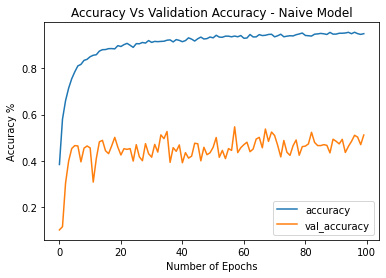

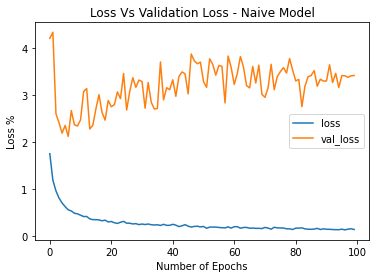

In [790]:
plot_losses(naive_model, 'Naive Model')

In [724]:
model_evaluate(naive_model, X_test, y_test)

Test loss: 3.2486376762390137
Test accuracy: 0.375


**Confusion Matrix**

The true accuracy can be found on the diagonal of the confusion matrix. For example, there is a 11% chance for the CNN to correctly identify `BoxingPunchingBag` class. There are some interesting results from the confusion matrix. It seems that each class can be most easily misclassified with `Lunges` and `HorseRace`. I would understand if `HorseRace` being easily misclassified with `HorseRiding` but that is not the case. We continue to try to optimize the model to garner better results. 

In [923]:
# find number of samples 
filesname = test_generator.filenames
nb_samples = len(filesname)

# Calculate the predictions
predict_probas = naive_model.predict(test_generator, steps = np.ceil(nb_samples/32))

In [934]:
# Convert probs to label encoding
y_predict = np.argmax(predict_probas, axis=1)

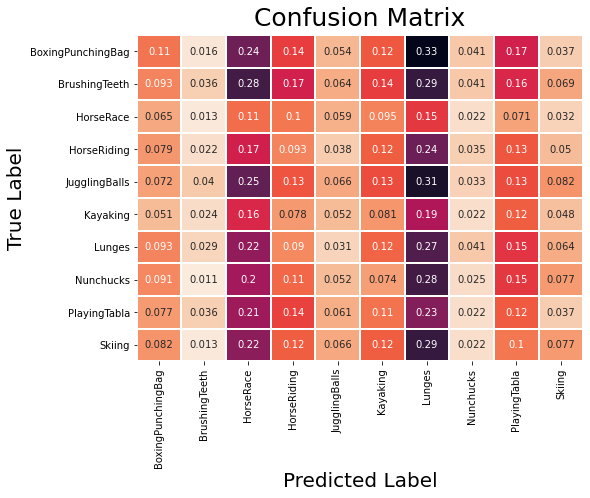

In [956]:
# Create Confusion Matrix

from sklearn.metrics import confusion_matrix
y_test_labels = np.argmax(y_test, axis=1)

# generate confusion matrix 
cf_matrix = confusion_matrix(y_test_labels, y_predict)
normalized_conf_mat = cf_matrix / cf_matrix.sum(axis=1)

# plot
plt.figure(figsize=(8,6))
sns.heatmap(normalized_conf_mat,
            annot=True,
            cbar=False,
            xticklabels = category_names,
            yticklabels = category_names,
            cmap="rocket_r",
            linewidths=1)

plt.title('Confusion Matrix', size = 25, y = 1.01)
plt.xlabel('Predicted Label', size = 20)
plt.ylabel('True Label', size = 20)
plt.show()

### Naive Model 2 

Lets just adjusting the optimizer to learn a bit slower. Our aim to reduced the inital accuracy score. Currently, we are using the adam optimizer, the default learning rate is 0.001. Let's try to lower the learning rate down a magnitude of 100 and look at the results.

In [798]:
# typically neurons are in powers of 2 starting from 32 
naive_model2 = Sequential()

# Create simple CNN model architecture with Pooling for dimensionality reduction 
# and Dropout to reduce overfitting
naive_model2.add(Conv2D(64, kernel_size=(3, 3), activation = 'relu', input_shape = (24, 32, 1), kernel_regularizer='l2'))
naive_model2.add(MaxPooling2D(pool_size=(2, 2)))
naive_model2.add(Dropout(0.25))                      
naive_model2.add(BatchNormalization()) 

naive_model2.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer='l2'))
naive_model2.add(MaxPooling2D(pool_size=(2, 2)))
naive_model2.add(Dropout(0.25))
naive_model2.add(BatchNormalization()) 

naive_model2.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer='l2'))
naive_model2.add(MaxPooling2D(pool_size=(2, 2)))
naive_model2.add(Dropout(0.25))
naive_model2.add(BatchNormalization()) 

# Flatten the output of our convolutional layers        
naive_model2.add(Flatten())

# Add dense layers
naive_model2.add(Dense(64, activation='relu'))
naive_model2.add(Dense(32, activation='relu'))
naive_model2.add(Dense(10, activation='softmax'))

# Print out a summary of the network
naive_model2.summary()

Model: "sequential_111"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_416 (Conv2D)          (None, 22, 30, 64)        640       
_________________________________________________________________
max_pooling2d_161 (MaxPoolin (None, 11, 15, 64)        0         
_________________________________________________________________
dropout_383 (Dropout)        (None, 11, 15, 64)        0         
_________________________________________________________________
batch_normalization_383 (Bat (None, 11, 15, 64)        256       
_________________________________________________________________
conv2d_417 (Conv2D)          (None, 9, 13, 128)        73856     
_________________________________________________________________
max_pooling2d_162 (MaxPoolin (None, 4, 6, 128)         0         
_________________________________________________________________
dropout_384 (Dropout)        (None, 4, 6, 128)      

In [799]:
# Compile the model with the desired loss function, optimizer, and metric(s) to track
naive_model2.compile(loss = 'categorical_crossentropy',
                  optimizer = keras.optimizers.Adam(0.00001),
                  metrics = ['accuracy'])

# Use an early stopping callback to stop training
# once we no longer have improvements in our validation loss
early_stop = EarlyStopping(monitor='val_loss', 
                           patience=2, 
                           mode='min', 
                           verbose=1)

In [800]:
naive_model2.fit(train_generator,
              epochs=150,
              validation_data = validation_generator
              )

Epoch 1/150
223/223 [==============================] - 13s 58ms/step - loss: 4.7216 - accuracy: 0.0992 - val_loss: 4.5295 - val_accuracy: 0.0692
Epoch 2/150
223/223 [==============================] - 13s 57ms/step - loss: 4.5934 - accuracy: 0.1196 - val_loss: 4.5376 - val_accuracy: 0.1024
Epoch 3/150
223/223 [==============================] - 13s 57ms/step - loss: 4.4976 - accuracy: 0.1391 - val_loss: 4.4453 - val_accuracy: 0.1277
Epoch 4/150
223/223 [==============================] - 13s 57ms/step - loss: 4.4320 - accuracy: 0.1532 - val_loss: 4.3569 - val_accuracy: 0.1344
Epoch 5/150
223/223 [==============================] - 13s 57ms/step - loss: 4.3650 - accuracy: 0.1743 - val_loss: 4.3092 - val_accuracy: 0.1502
Epoch 6/150
223/223 [==============================] - 13s 57ms/step - loss: 4.3200 - accuracy: 0.1844 - val_loss: 4.2693 - val_accuracy: 0.1659
Epoch 7/150
223/223 [==============================] - 13s 57ms/step - loss: 4.2510 - accuracy: 0.2034 - val_loss: 4.2339 - val_ac

223/223 [==============================] - 13s 57ms/step - loss: 1.8437 - accuracy: 0.6818 - val_loss: 2.6798 - val_accuracy: 0.4021
Epoch 114/150
223/223 [==============================] - 13s 57ms/step - loss: 1.8359 - accuracy: 0.6819 - val_loss: 2.6729 - val_accuracy: 0.4078
Epoch 115/150
223/223 [==============================] - 13s 57ms/step - loss: 1.8360 - accuracy: 0.6791 - val_loss: 2.6970 - val_accuracy: 0.3965
Epoch 116/150
223/223 [==============================] - 13s 57ms/step - loss: 1.8175 - accuracy: 0.6809 - val_loss: 2.6848 - val_accuracy: 0.4072
Epoch 117/150
223/223 [==============================] - 13s 57ms/step - loss: 1.8128 - accuracy: 0.6806 - val_loss: 2.6816 - val_accuracy: 0.4055
Epoch 118/150
223/223 [==============================] - 13s 57ms/step - loss: 1.7990 - accuracy: 0.6881 - val_loss: 2.6851 - val_accuracy: 0.3976
Epoch 119/150
223/223 [==============================] - 13s 57ms/step - loss: 1.7866 - accuracy: 0.6870 - val_loss: 2.6582 - val_ac

In [801]:
save_model(naive_model2, 'naive_model2')
#naive_model2 = keras.models.load_model('data/saved_models/naive_model2')

INFO:tensorflow:Assets written to: data/saved_models/naive_model2\assets


In [802]:
plot_history(naive_model2, 'Naive Model2')

Naive Model2 History - Results from Each Epoch


,loss,accuracy,val_loss,val_accuracy
0,4.721645,0.099184,4.529522,0.069179
1,4.593418,0.119584,4.537562,0.102362
2,4.497552,0.139139,4.445275,0.127672
3,4.431967,0.153208,4.356861,0.134421
4,4.364992,0.174311,4.309205,0.150169
...,...,...,...,...
145,1.521504,0.733399,2.617450,0.410011
146,1.502579,0.736494,2.554608,0.421260
147,1.498340,0.739730,2.545494,0.421260
148,1.487036,0.743106,2.589513,0.417323


We can see from the graphs below we successful in reducing the initial learning accuracy. However, we can see that our overfiting increased and our accuracy and val_accuracy is lowered. We can conclude we are moving in the right direction.

|  Model Name (Best Weights) | Accuracy | Validation Accuracy | Epoch |
|-------------|----------|---------------------|-------|
| Naive Model |    91%   |         51%         |  34   | 
| Naive Model2 |    69%   |         41%         |  120   | 

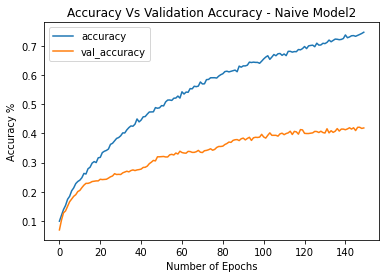

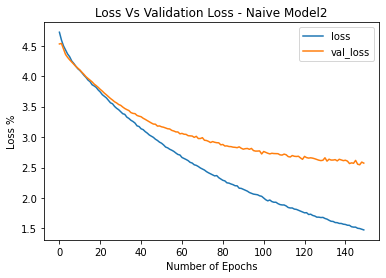

In [803]:
plot_losses(naive_model2, 'Naive Model2')

### Naive Model 3

I think the learning rate was too low last time. This time we will decrease the default adam learning rate by a magnitude of 10. We will set the learning rate to 0.0001. Lets check out the result.  

In [791]:
# typically neurons are in powers of 2 starting from 32 
naive_model3 = Sequential()

# Create simple CNN model architecture with Pooling for dimensionality reduction 
# and Dropout to reduce overfitting
naive_model3.add(Conv2D(64, kernel_size=(3, 3), activation = 'relu', input_shape = (24, 32, 1), kernel_regularizer='l2'))
naive_model3.add(MaxPooling2D(pool_size=(2, 2)))
naive_model3.add(Dropout(0.25))                     # stackoverflow explains ordering of dropout and batchnormalization 
naive_model3.add(BatchNormalization()) 

naive_model3.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer='l2'))
naive_model3.add(MaxPooling2D(pool_size=(2, 2)))
naive_model3.add(Dropout(0.25))
naive_model3.add(BatchNormalization()) 

naive_model3.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer='l2'))
naive_model3.add(MaxPooling2D(pool_size=(2, 2)))
naive_model3.add(Dropout(0.25))
naive_model3.add(BatchNormalization()) 

# Flatten the output of our convolutional layers           # stackoverflow on dropput placement Conv2D -> RELU -> DROP none on output layers
naive_model3.add(Flatten())

# Add dense layers
naive_model3.add(Dense(64, activation='relu'))
naive_model3.add(Dense(32, activation='relu'))
naive_model3.add(Dense(10, activation='softmax'))

# Print out a summary of the network
naive_model3.summary()

Model: "sequential_110"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_413 (Conv2D)          (None, 22, 30, 64)        640       
_________________________________________________________________
max_pooling2d_158 (MaxPoolin (None, 11, 15, 64)        0         
_________________________________________________________________
dropout_380 (Dropout)        (None, 11, 15, 64)        0         
_________________________________________________________________
batch_normalization_380 (Bat (None, 11, 15, 64)        256       
_________________________________________________________________
conv2d_414 (Conv2D)          (None, 9, 13, 128)        73856     
_________________________________________________________________
max_pooling2d_159 (MaxPoolin (None, 4, 6, 128)         0         
_________________________________________________________________
dropout_381 (Dropout)        (None, 4, 6, 128)      

In [792]:
# Compile the model with the desired loss function, optimizer, and metric(s) to track
naive_model3.compile(loss = 'categorical_crossentropy',
                  optimizer = keras.optimizers.Adam(0.0001),
                  metrics = ['accuracy'])

# Use an early stopping callback to stop training
# once we no longer have improvements in our validation loss
early_stop = EarlyStopping(monitor='val_loss', 
                           patience=2, 
                           mode='min', 
                           verbose=1)

In [793]:
naive_model3.fit(train_generator,
              epochs=100,
              validation_data = validation_generator
              )

Epoch 1/100
223/223 [==============================] - 13s 59ms/step - loss: 4.3307 - accuracy: 0.1714 - val_loss: 4.2936 - val_accuracy: 0.1091
Epoch 2/100
223/223 [==============================] - 13s 57ms/step - loss: 3.8775 - accuracy: 0.2825 - val_loss: 4.1819 - val_accuracy: 0.1035
Epoch 3/100
223/223 [==============================] - 13s 56ms/step - loss: 3.5489 - accuracy: 0.3524 - val_loss: 3.7929 - val_accuracy: 0.2621
Epoch 4/100
223/223 [==============================] - 13s 57ms/step - loss: 3.2641 - accuracy: 0.4169 - val_loss: 3.5723 - val_accuracy: 0.3279
Epoch 5/100
223/223 [==============================] - 13s 56ms/step - loss: 3.0067 - accuracy: 0.4676 - val_loss: 3.4468 - val_accuracy: 0.3279
Epoch 6/100
223/223 [==============================] - 13s 56ms/step - loss: 2.8033 - accuracy: 0.4944 - val_loss: 3.3073 - val_accuracy: 0.3363
Epoch 7/100
223/223 [==============================] - 13s 56ms/step - loss: 2.5931 - accuracy: 0.5276 - val_loss: 3.2448 - val_ac

In [797]:
# save model 
naive_model3.save('data/saved_models/naive_model3')
#naive_model3 = keras.models.load_model('data/saved_models/naive_model3')

INFO:tensorflow:Assets written to: data/saved_models/naive_model3\assets


We can see from the graphs below we were also able to reduce the inital accuracy rate to a similar range of a adam learning rate of 0.00001. Our accuracy and val_accuracy has also returned a similar range of the `naive model`. 

|  Model Name (Best Weights) | Accuracy | Validation Accuracy | Epoch |
|-------------|----------|---------------------|-------|
| Naive Model |    91%   |         51%         |  34   | 
| Naive Model2 |    69%   |         41%         |  120   |
| Naive Model3 |    94%   |         54%         |  100   |

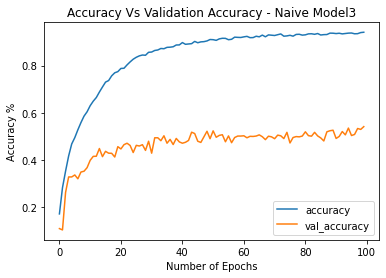

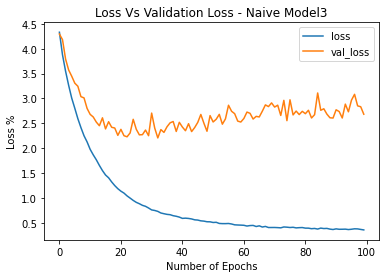

In [796]:
plot_losses(naive_model3, 'Naive Model3')

### Naive Model 4

This time lets try reducing the layers and the number of neurons

In [804]:
# typically neurons are in powers of 2 starting from 32 
naive_model4 = Sequential()

# Create simple CNN model architecture with Pooling for dimensionality reduction 
# and Dropout to reduce overfitting
naive_model4.add(Conv2D(32, kernel_size=(3, 3), activation = 'relu', input_shape = (24, 32, 1)))
naive_model4.add(MaxPooling2D(pool_size=(2, 2)))
naive_model4.add(Dropout(0.25))                     # stackoverflow explains ordering of dropout and batchnormalization 
naive_model4.add(BatchNormalization()) 

naive_model4.add(Conv2D(32, (3, 3), activation='relu'))
naive_model4.add(MaxPooling2D(pool_size=(2, 2)))
naive_model4.add(Dropout(0.25))
naive_model4.add(BatchNormalization())

# Flatten the output of our convolutional layers           # stackoverflow on dropput placement Conv2D -> RELU -> DROP none on output layers
naive_model4.add(Flatten())

# Add dense layers
naive_model4.add(Dense(10, activation='softmax'))

# Print out a summary of the network
naive_model4.summary()

Model: "sequential_112"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_419 (Conv2D)          (None, 22, 30, 32)        320       
_________________________________________________________________
max_pooling2d_164 (MaxPoolin (None, 11, 15, 32)        0         
_________________________________________________________________
dropout_386 (Dropout)        (None, 11, 15, 32)        0         
_________________________________________________________________
batch_normalization_386 (Bat (None, 11, 15, 32)        128       
_________________________________________________________________
conv2d_420 (Conv2D)          (None, 9, 13, 32)         9248      
_________________________________________________________________
max_pooling2d_165 (MaxPoolin (None, 4, 6, 32)          0         
_________________________________________________________________
dropout_387 (Dropout)        (None, 4, 6, 32)       

In [805]:
# Compile the model with the desired loss function, optimizer, and metric(s) to track
naive_model4.compile(loss = 'categorical_crossentropy',
                  optimizer = keras.optimizers.Adam(0.0001),
                  metrics = ['accuracy'])

# Use an early stopping callback to stop training
# once we no longer have improvements in our validation loss
early_stop = EarlyStopping(monitor='val_loss', 
                           patience=2, 
                           mode='min', 
                           verbose=1)

In [806]:
naive_model4.fit(train_generator,
              epochs=100,
              validation_data = validation_generator
              )

Epoch 1/100
223/223 [==============================] - 12s 53ms/step - loss: 2.7090 - accuracy: 0.1564 - val_loss: 2.5405 - val_accuracy: 0.1243
Epoch 2/100
223/223 [==============================] - 12s 53ms/step - loss: 2.3127 - accuracy: 0.2417 - val_loss: 2.4749 - val_accuracy: 0.1445
Epoch 3/100
223/223 [==============================] - 12s 53ms/step - loss: 2.0932 - accuracy: 0.3094 - val_loss: 2.0782 - val_accuracy: 0.2835
Epoch 4/100
223/223 [==============================] - 12s 53ms/step - loss: 1.9634 - accuracy: 0.3492 - val_loss: 2.0116 - val_accuracy: 0.3195
Epoch 5/100
223/223 [==============================] - 12s 53ms/step - loss: 1.8337 - accuracy: 0.3820 - val_loss: 1.9286 - val_accuracy: 0.3386
Epoch 6/100
223/223 [==============================] - 12s 53ms/step - loss: 1.7316 - accuracy: 0.4149 - val_loss: 1.9438 - val_accuracy: 0.3279
Epoch 7/100
223/223 [==============================] - 12s 53ms/step - loss: 1.6459 - accuracy: 0.4408 - val_loss: 1.9768 - val_ac

In [807]:
# save model 
naive_model4.save('data/saved_models/naive_model4')
#naive_model4 = keras.models.load_model('data/saved_models/naive_model4')

INFO:tensorflow:Assets written to: data/saved_models/naive_model4\assets


We can see from the graph below, if we reduce the number of layers and neurons. Our accuracy takes a hit. We need to continue to try to optimize our model. 

|  Model Name (Best Weights) | Accuracy | Validation Accuracy | Epoch |
|-------------|----------|---------------------|-------|
| Naive Model |    91%   |         51%         |  34   | 
| Naive Model2 |    69%   |         41%         |  120   |
| Naive Model3 |    94%   |         54%         |  100   |
| Naive Model4 |    83%   |         50%         |  98   |

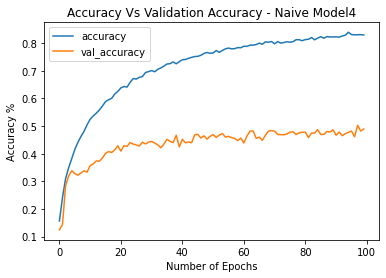

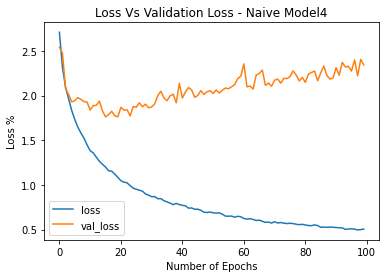

In [808]:
plot_losses(naive_model4, 'Naive Model4')

### Naive Model 5

This will a copy of naive model 3 but with higher dropout rate. Lets see the affects on the overfit. 

In [1100]:
# typically neurons are in powers of 2 starting from 32 
naive_model5 = Sequential()

# Create simple CNN model architecture with Pooling for dimensionality reduction 
# and Dropout to reduce overfitting
naive_model5.add(Conv2D(64, kernel_size=(3, 3), activation = 'relu', input_shape = (24, 32, 1)))
naive_model5.add(MaxPooling2D(pool_size=(2, 2)))
naive_model5.add(Dropout(0.3))                     # stackoverflow explains ordering of dropout and batchnormalization 
naive_model5.add(BatchNormalization()) 

naive_model5.add(Conv2D(128, (3, 3), activation='relu'))
naive_model5.add(MaxPooling2D(pool_size=(2, 2)))
naive_model5.add(Dropout(0.3))
naive_model5.add(BatchNormalization()) 

naive_model5.add(Conv2D(128, (3, 3), activation='relu'))
naive_model5.add(MaxPooling2D(pool_size=(2, 2)))
naive_model5.add(Dropout(0.3))
naive_model5.add(BatchNormalization()) 

# Flatten the output of our convolutional layers           # stackoverflow on dropput placement Conv2D -> RELU -> DROP none on output layers
naive_model5.add(Flatten())

# Add dense layers
naive_model5.add(Dense(64, activation='relu'))
naive_model5.add(Dense(32, activation='relu'))
naive_model5.add(Dense(10, activation='softmax'))

# Print out a summary of the network
naive_model5.summary()

Model: "sequential_115"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_522 (Conv2D)          (None, 22, 30, 64)        640       
_________________________________________________________________
max_pooling2d_173 (MaxPoolin (None, 11, 15, 64)        0         
_________________________________________________________________
dropout_411 (Dropout)        (None, 11, 15, 64)        0         
_________________________________________________________________
batch_normalization_504 (Bat (None, 11, 15, 64)        256       
_________________________________________________________________
conv2d_523 (Conv2D)          (None, 9, 13, 128)        73856     
_________________________________________________________________
max_pooling2d_174 (MaxPoolin (None, 4, 6, 128)         0         
_________________________________________________________________
dropout_412 (Dropout)        (None, 4, 6, 128)      

In [1101]:
# Compile the model with the desired loss function, optimizer, and metric(s) to track
naive_model5.compile(loss = 'categorical_crossentropy',
                  optimizer = keras.optimizers.Adam(0.00001),
                  metrics = ['accuracy'])

In [1102]:
naive_model5.fit(train_generator,
              epochs=100,
              validation_data = validation_generator
              )

Epoch 1/100
223/223 [==============================] - 15s 66ms/step - loss: 2.6847 - accuracy: 0.1058 - val_loss: 2.4189 - val_accuracy: 0.1220
Epoch 2/100
223/223 [==============================] - 14s 65ms/step - loss: 2.6179 - accuracy: 0.1204 - val_loss: 2.4387 - val_accuracy: 0.1220
Epoch 3/100
223/223 [==============================] - 14s 65ms/step - loss: 2.5529 - accuracy: 0.1293 - val_loss: 2.4020 - val_accuracy: 0.1209
Epoch 4/100
223/223 [==============================] - 14s 65ms/step - loss: 2.4908 - accuracy: 0.1459 - val_loss: 2.3620 - val_accuracy: 0.1676
Epoch 5/100
223/223 [==============================] - 15s 66ms/step - loss: 2.4619 - accuracy: 0.1407 - val_loss: 2.3340 - val_accuracy: 0.1659
Epoch 6/100
223/223 [==============================] - 15s 65ms/step - loss: 2.4053 - accuracy: 0.1573 - val_loss: 2.3144 - val_accuracy: 0.1625
Epoch 7/100
223/223 [==============================] - 14s 65ms/step - loss: 2.3715 - accuracy: 0.1660 - val_loss: 2.2996 - val_ac

In [1104]:
# save model 
naive_model5.save('data/saved_models/naive_model5')
#naive_model5 = keras.models.load_model('data/saved_models/naive_model5')

INFO:tensorflow:Assets written to: data/saved_models/naive_model5\assets


Increasing the dropout rate seems to have negatively affect the model. 

|  Model Name (Best Weights) | Accuracy | Validation Accuracy | Epoch |
|-------------|----------|---------------------|-------|
| Naive Model |    91%   |         51%         |  34   | 
| Naive Model2 |    69%   |         41%         |  120   |
| Naive Model3 |    94%   |         54%         |  100   |
| Naive Model4 |    83%   |         50%         |  98   |
| Naive Model5 |    50%   |         28%         |  100   |

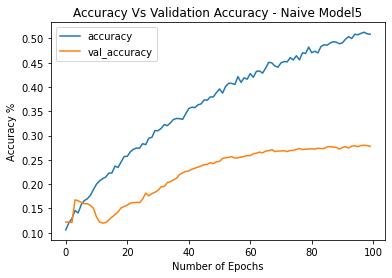

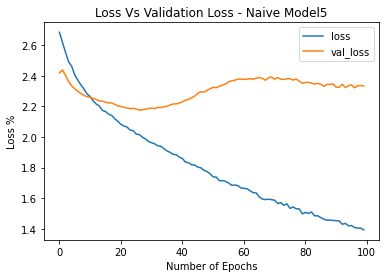

In [1105]:
plot_losses(naive_model5, 'Naive Model5')

### Naive Model 6

Lets try to increase accuracy and val_accuracy by increasing the number of neurons

In [214]:
# typically neurons are in powers of 2 starting from 32 
naive_model6 = Sequential()

# Create simple CNN model architecture with Pooling for dimensionality reduction 
# and Dropout to reduce overfitting
naive_model6.add(Conv2D(64, kernel_size=(3, 3), activation = 'relu', input_shape = (24, 32, 1)))
#naive_model6.add(MaxPooling2D(pool_size=(2, 2)))
naive_model6.add(Dropout(0.3))                     # stackoverflow explains ordering of dropout and batchnormalization 
naive_model6.add(BatchNormalization()) 

naive_model6.add(Conv2D(128, (3, 3), activation='relu'))
#naive_model6.add(MaxPooling2D(pool_size=(2, 2)))
naive_model6.add(Dropout(0.3))
naive_model6.add(BatchNormalization()) 

naive_model6.add(Conv2D(256, (3, 3), activation='relu'))
naive_model6.add(MaxPooling2D(pool_size=(2, 2)))
naive_model6.add(Dropout(0.3))
naive_model6.add(BatchNormalization()) 

naive_model6.add(Conv2D(128, (3, 3), activation='relu'))
naive_model6.add(MaxPooling2D(pool_size=(2, 2)))
naive_model6.add(Dropout(0.3))
naive_model6.add(BatchNormalization()) 

# Flatten the output of our convolutional layers           # stackoverflow on dropput placement Conv2D -> RELU -> DROP none on output layers
naive_model6.add(Flatten())

# Add dense layers
naive_model6.add(Dense(64, activation='relu'))
naive_model6.add(Dense(32, activation='relu'))
naive_model6.add(Dense(10, activation='softmax'))

# Print out a summary of the network
naive_model6.summary()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_81 (Conv2D)           (None, 22, 30, 64)        640       
_________________________________________________________________
dropout_71 (Dropout)         (None, 22, 30, 64)        0         
_________________________________________________________________
batch_normalization_71 (Batc (None, 22, 30, 64)        256       
_________________________________________________________________
conv2d_82 (Conv2D)           (None, 20, 28, 128)       73856     
_________________________________________________________________
dropout_72 (Dropout)         (None, 20, 28, 128)       0         
_________________________________________________________________
batch_normalization_72 (Batc (None, 20, 28, 128)       512       
_________________________________________________________________
conv2d_83 (Conv2D)           (None, 18, 26, 256)     

In [218]:
# Compile the model with the desired loss function, optimizer, and metric(s) to track
naive_model6.compile(loss = 'categorical_crossentropy',
                  optimizer = keras.optimizers.Adam(0.0001),
                  metrics = ['accuracy'])

# Use an early stopping callback to stop training
# once we no longer have improvements in our validation loss
early_stop = EarlyStopping(monitor='val_loss', 
                           patience=2, 
                           mode='min', 
                           verbose=1)

In [219]:
naive_model6.fit(train_generator,
              epochs=100,
              validation_data = validation_generator, 
              callbacks=[early_stop]
              )

Epoch 1/150
223/223 [==============================] - 41s 182ms/step - loss: 2.0844 - accuracy: 0.2638 - val_loss: 2.9321 - val_accuracy: 0.1192
Epoch 2/150
223/223 [==============================] - 40s 181ms/step - loss: 1.7922 - accuracy: 0.3741 - val_loss: 2.2846 - val_accuracy: 0.1940
Epoch 3/150
223/223 [==============================] - 41s 182ms/step - loss: 1.5854 - accuracy: 0.4501 - val_loss: 2.2120 - val_accuracy: 0.2610
Epoch 4/150
223/223 [==============================] - 40s 182ms/step - loss: 1.4086 - accuracy: 0.5262 - val_loss: 2.1230 - val_accuracy: 0.2880
Epoch 5/150
223/223 [==============================] - 40s 181ms/step - loss: 1.2822 - accuracy: 0.5658 - val_loss: 2.0435 - val_accuracy: 0.3256
Epoch 6/150
223/223 [==============================] - 40s 181ms/step - loss: 1.1395 - accuracy: 0.6106 - val_loss: 2.0072 - val_accuracy: 0.3436
Epoch 7/150
223/223 [==============================] - 41s 182ms/step - loss: 1.0488 - accuracy: 0.6404 - val_loss: 1.9874 -

In [1106]:
# save model 
naive_model6.save('data/saved_models/naive_model6')
#naive_model6 = keras.models.load_model('data/saved_models/naive_model6')

INFO:tensorflow:Assets written to: data/saved_models/naive_model6\assets


I used `EarlyStopping` for this training. It seems to have stopped at 9 epoch got a 40% validation accuracy. 

|  Model Name (Best Weights) | Accuracy | Validation Accuracy | Epoch |
|-------------|----------|---------------------|-------|
| Naive Model |    91%   |         51%         |  34   | 
| Naive Model2 |    69%   |         41%         |  120   |
| Naive Model3 |    94%   |         54%         |  100   |
| Naive Model4 |    83%   |         50%         |  98   |
| Naive Model5 |    50%   |         28%         |  100   |
| Naive Model6 |    88%   |         40%         |  9   |

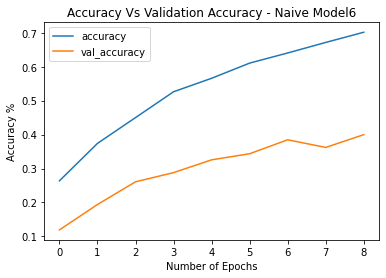

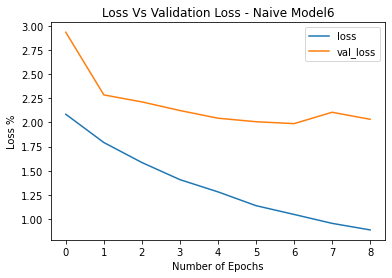

In [220]:
plot_losses(naive_model6, 'Naive Model6')

### Naive Model 7

Lets try to increase accuracy and val_accuracy by increasing the number of neurons

In [291]:
# typically neurons are in powers of 2 starting from 32 
naive_model7 = Sequential()

# Create simple CNN model architecture with Pooling for dimensionality reduction 
# and Dropout to reduce overfitting
naive_model7.add(Conv2D(64, kernel_size=(3, 3), activation = 'relu', input_shape = (24, 32, 1), kernel_regularizer='l2'))
#naive_model7.add(MaxPooling2D(pool_size=(2, 2)))
naive_model7.add(Dropout(0.3))                     # stackoverflow explains ordering of dropout and batchnormalization 
naive_model7.add(BatchNormalization()) 

naive_model7.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer='l2'))
#naive_model7.add(MaxPooling2D(pool_size=(2, 2)))
naive_model7.add(Dropout(0.3))
naive_model7.add(BatchNormalization()) 

naive_model7.add(Conv2D(256, (3, 3), activation='relu', kernel_regularizer='l2'))
#naive_model7.add(MaxPooling2D(pool_size=(2, 2)))
naive_model7.add(Dropout(0.3))
naive_model7.add(BatchNormalization()) 

naive_model7.add(Conv2D(512, (3, 3), activation='relu', kernel_regularizer='l2'))
#naive_model7.add(MaxPooling2D(pool_size=(2, 2)))
naive_model7.add(Dropout(0.3))
naive_model7.add(BatchNormalization()) 

naive_model7.add(Conv2D(256, (3, 3), activation='relu', kernel_regularizer='l2'))
#naive_model7.add(MaxPooling2D(pool_size=(2, 2)))
naive_model7.add(Dropout(0.3))
naive_model7.add(BatchNormalization()) 

# Flatten the output of our convolutional layers           # stackoverflow on dropput placement Conv2D -> RELU -> DROP none on output layers
naive_model7.add(Flatten())

# Add dense layers
naive_model7.add(Dense(10, activation='softmax'))

# Print out a summary of the network
naive_model7.summary()

Model: "sequential_57"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_233 (Conv2D)          (None, 22, 30, 64)        640       
_________________________________________________________________
dropout_204 (Dropout)        (None, 22, 30, 64)        0         
_________________________________________________________________
batch_normalization_204 (Bat (None, 22, 30, 64)        256       
_________________________________________________________________
conv2d_234 (Conv2D)          (None, 20, 28, 128)       73856     
_________________________________________________________________
dropout_205 (Dropout)        (None, 20, 28, 128)       0         
_________________________________________________________________
batch_normalization_205 (Bat (None, 20, 28, 128)       512       
_________________________________________________________________
conv2d_235 (Conv2D)          (None, 18, 26, 256)     

In [292]:
# Compile the model with the desired loss function, optimizer, and metric(s) to track
naive_model7.compile(loss = 'categorical_crossentropy',
                  optimizer = keras.optimizers.Adam(0.0001),
                  metrics = ['accuracy'])

# Use an early stopping callback to stop training
# once we no longer have improvements in our validation loss
early_stop = EarlyStopping(monitor='val_loss', 
                           patience=2, 
                           mode='min', 
                           verbose=1)

In [293]:
naive_model7.fit(train_generator,
              epochs=150,
              validation_data = validation_generator, 
              callbacks=[early_stop]
              )

Epoch 1/150
223/223 [==============================] - 151s 676ms/step - loss: 11.3447 - accuracy: 0.3469 - val_loss: 16.2523 - val_accuracy: 0.1024
Epoch 2/150
223/223 [==============================] - 150s 674ms/step - loss: 10.2137 - accuracy: 0.5242 - val_loss: 16.6542 - val_accuracy: 0.1288
Epoch 3/150
223/223 [==============================] - 154s 691ms/step - loss: 9.4284 - accuracy: 0.5995 - val_loss: 11.9097 - val_accuracy: 0.2677
Epoch 4/150
223/223 [==============================] - 154s 691ms/step - loss: 8.7445 - accuracy: 0.6553 - val_loss: 11.0751 - val_accuracy: 0.3808
Epoch 5/150
223/223 [==============================] - 150s 674ms/step - loss: 8.1243 - accuracy: 0.6915 - val_loss: 10.5952 - val_accuracy: 0.4319
Epoch 6/150
223/223 [==============================] - 150s 671ms/step - loss: 7.4640 - accuracy: 0.7349 - val_loss: 9.7455 - val_accuracy: 0.4370
Epoch 7/150
223/223 [==============================] - 150s 674ms/step - loss: 6.9651 - accuracy: 0.7434 - val_

In [1107]:
# save model 
naive_model7.save('data/saved_models/naive_model7')
#naive_model7 = keras.models.load_model('data/saved_models/naive_model7')

INFO:tensorflow:Assets written to: data/saved_models/naive_model7\assets


I included `EarlyStopping` on this model. There is no considerable improvements versus prior models. 

|  Model Name (Best Weights) | Accuracy | Validation Accuracy | Epoch |
|-------------|----------|---------------------|-------|
| Naive Model |    91%   |         51%         |  34   | 
| Naive Model2 |    69%   |         41%         |  120   |
| Naive Model3 |    94%   |         54%         |  100   |
| Naive Model4 |    83%   |         50%         |  98   |
| Naive Model5 |    50%   |         28%         |  100   |
| Naive Model6 |    88%   |         40%         |  9   |
| Naive Model7 |    85%   |         47%         |  17   |

1/1 [==============================] - 0s 0s/step - loss: 7.2339 - accuracy: 0.3438
Test loss: 7.2339396476745605
Test accuracy: 0.34375


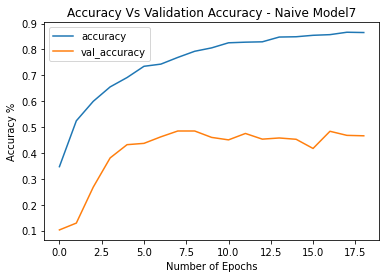

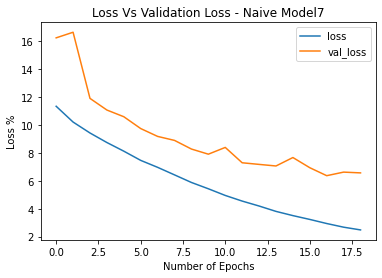

In [295]:
plot_losses(naive_model7, 'Naive Model7')

### Naive Model 9

Copy of Naive Model 7 but increased dropout to 0.4 

In [411]:
# typically neurons are in powers of 2 starting from 32 
naive_model9 = Sequential()

# Create simple CNN model architecture with Pooling for dimensionality reduction 
# and Dropout to reduce overfitting
naive_model9.add(Conv2D(64, kernel_size=(3, 3), activation = 'relu', input_shape = (24, 32, 1), kernel_regularizer='l2'))
#naive_model7.add(MaxPooling2D(pool_size=(2, 2)))
naive_model9.add(Dropout(0.4))                     # stackoverflow explains ordering of dropout and batchnormalization 
naive_model9.add(BatchNormalization()) 

naive_model9.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer='l2'))
#naive_model7.add(MaxPooling2D(pool_size=(2, 2)))
naive_model9.add(Dropout(0.4))
naive_model9.add(BatchNormalization()) 

naive_model9.add(Conv2D(256, (3, 3), activation='relu', kernel_regularizer='l2'))
#naive_model7.add(MaxPooling2D(pool_size=(2, 2)))
naive_model9.add(Dropout(0.4))
naive_model9.add(BatchNormalization()) 

naive_model9.add(Conv2D(512, (3, 3), activation='relu', kernel_regularizer='l2'))
#naive_model7.add(MaxPooling2D(pool_size=(2, 2)))
naive_model9.add(Dropout(0.4))
naive_model9.add(BatchNormalization()) 

naive_model9.add(Conv2D(256, (3, 3), activation='relu', kernel_regularizer='l2'))
#naive_model7.add(MaxPooling2D(pool_size=(2, 2)))
naive_model9.add(Dropout(0.4))
naive_model9.add(BatchNormalization()) 

# Flatten the output of our convolutional layers           # stackoverflow on dropput placement Conv2D -> RELU -> DROP none on output layers
naive_model9.add(Flatten())

# Add dense layers
naive_model9.add(Dense(10, activation='softmax'))

# Print out a summary of the network
naive_model9.summary()

Model: "sequential_94"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_387 (Conv2D)          (None, 22, 30, 64)        640       
_________________________________________________________________
dropout_355 (Dropout)        (None, 22, 30, 64)        0         
_________________________________________________________________
batch_normalization_355 (Bat (None, 22, 30, 64)        256       
_________________________________________________________________
conv2d_388 (Conv2D)          (None, 20, 28, 128)       73856     
_________________________________________________________________
dropout_356 (Dropout)        (None, 20, 28, 128)       0         
_________________________________________________________________
batch_normalization_356 (Bat (None, 20, 28, 128)       512       
_________________________________________________________________
conv2d_389 (Conv2D)          (None, 18, 26, 256)     

In [412]:
# Compile the model with the desired loss function, optimizer, and metric(s) to track
naive_model9.compile(loss = 'categorical_crossentropy',
                  optimizer = keras.optimizers.Adam(0.0001),
                  metrics = ['accuracy'])

# Use an early stopping callback to stop training
# once we no longer have improvements in our validation loss
early_stop = EarlyStopping(monitor='val_loss', 
                           patience=2, 
                           mode='min', 
                           verbose=1)

In [413]:
naive_model9.fit(train_generator,
              epochs=150,
              validation_data = validation_generator, 
              callbacks=[early_stop]
              )

Epoch 1/150
223/223 [==============================] - 154s 691ms/step - loss: 11.5096 - accuracy: 0.2967 - val_loss: 16.5199 - val_accuracy: 0.1024
Epoch 2/150
223/223 [==============================] - 153s 685ms/step - loss: 10.4552 - accuracy: 0.4616 - val_loss: 15.9303 - val_accuracy: 0.1232
Epoch 3/150
223/223 [==============================] - 160s 718ms/step - loss: 9.6888 - accuracy: 0.5407 - val_loss: 11.9730 - val_accuracy: 0.2300
Epoch 4/150
223/223 [==============================] - 149s 667ms/step - loss: 8.9910 - accuracy: 0.6034 - val_loss: 10.5523 - val_accuracy: 0.3616
Epoch 5/150
223/223 [==============================] - 148s 665ms/step - loss: 8.3494 - accuracy: 0.6525 - val_loss: 9.9631 - val_accuracy: 0.4556
Epoch 6/150
223/223 [==============================] - 149s 667ms/step - loss: 7.7931 - accuracy: 0.6745 - val_loss: 10.0278 - val_accuracy: 0.4111
Epoch 7/150
223/223 [==============================] - 148s 664ms/step - loss: 7.2588 - accuracy: 0.6996 - val_

In [1108]:
# save model 
naive_model9.save('data/saved_models/naive_model9')
#naive_model9 = keras.models.load_model('data/saved_models/naive_model9')

INFO:tensorflow:Assets written to: data/saved_models/naive_model9\assets


With `EarlyStopping` trigging, we do not see an improvement on model. 

|  Model Name (Best Weights) | Accuracy | Validation Accuracy | Epoch |
|-------------|----------|---------------------|-------|
| Naive Model |    91%   |         51%         |  34   | 
| Naive Model2 |    69%   |         41%         |  120   |
| Naive Model3 |    94%   |         54%         |  100   |
| Naive Model4 |    83%   |         50%         |  98   |
| Naive Model5 |    50%   |         28%         |  100   |
| Naive Model6 |    88%   |         40%         |  9   |
| Naive Model7 |    85%   |         47%         |  17   |
| Naive Model9 |    80%   |         46%         |  14   |

In [766]:
plot_history(naive_model9, 'Naive Model9')

Naive Model9 History - Results from Each Epoch


,loss,accuracy,val_loss,val_accuracy
0,1.713818,0.408132,5.553323,0.102362
1,1.144856,0.596370,4.633214,0.102925
2,0.907177,0.685566,2.874297,0.253656
3,0.774327,0.737620,3.184420,0.303712
4,0.675557,0.764350,2.395838,0.398763
5,0.586621,0.801491,2.816312,0.356580
6,0.541267,0.812324,3.095968,0.349831
7,0.502410,0.825549,2.790871,0.420697
8,0.498968,0.835256,2.176976,0.484252
9,0.453145,0.845808,2.575025,0.452756


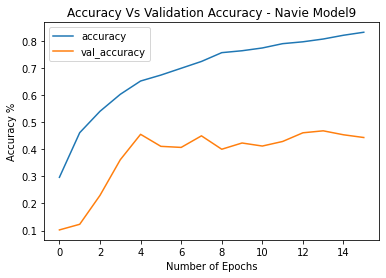

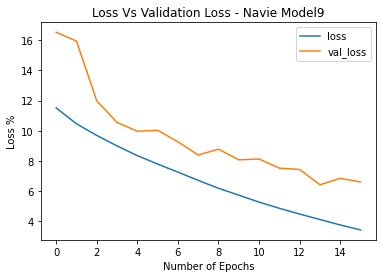

In [767]:
plot_losses(naive_model9, 'Navie Model9')

### Naive Model 8

Lets add activity_regularizer paramater 

In [809]:
# typically neurons are in powers of 2 starting from 32 
naive_model8 = Sequential()

# Create simple CNN model architecture with Pooling for dimensionality reduction 
# and Dropout to reduce overfitting
naive_model8.add(Conv2D(64, kernel_size=(3, 3), activation = 'relu', input_shape = (24, 32, 1)))
#naive_model7.add(MaxPooling2D(pool_size=(2, 2)))
naive_model8.add(Dropout(0.3))                     # stackoverflow explains ordering of dropout and batchnormalization 
naive_model8.add(BatchNormalization()) 

naive_model8.add(Conv2D(32, (3, 3), activation='relu'))
#naive_model7.add(MaxPooling2D(pool_size=(2, 2)))
naive_model8.add(Dropout(0.3))
naive_model8.add(BatchNormalization()) 

naive_model8.add(Conv2D(32, (3, 3), activation='relu'))
#naive_model7.add(MaxPooling2D(pool_size=(2, 2)))
naive_model8.add(Dropout(0.3))
naive_model8.add(BatchNormalization()) 

naive_model8.add(Conv2D(32, (3, 3), activation='relu'))
#naive_model7.add(MaxPooling2D(pool_size=(2, 2)))
naive_model8.add(Dropout(0.3))
naive_model8.add(BatchNormalization()) 

# naive_model8.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer='l2'))
# #naive_model7.add(MaxPooling2D(pool_size=(2, 2)))
# naive_model8.add(Dropout(0.3))
# naive_model8.add(BatchNormalization())

# Flatten the output of our convolutional layers           # stackoverflow on dropput placement Conv2D -> RELU -> DROP none on output layers
naive_model8.add(Flatten())

# Add dense layers
naive_model8.add(Dense(10, activation='softmax'))

# Print out a summary of the network
naive_model8.summary()

Model: "sequential_113"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_421 (Conv2D)          (None, 22, 30, 64)        640       
_________________________________________________________________
dropout_388 (Dropout)        (None, 22, 30, 64)        0         
_________________________________________________________________
batch_normalization_388 (Bat (None, 22, 30, 64)        256       
_________________________________________________________________
conv2d_422 (Conv2D)          (None, 20, 28, 32)        18464     
_________________________________________________________________
dropout_389 (Dropout)        (None, 20, 28, 32)        0         
_________________________________________________________________
batch_normalization_389 (Bat (None, 20, 28, 32)        128       
_________________________________________________________________
conv2d_423 (Conv2D)          (None, 18, 26, 32)     

In [810]:
# Compile the model with the desired loss function, optimizer, and metric(s) to track
naive_model8.compile(loss = 'categorical_crossentropy',
                  optimizer = keras.optimizers.Adam(0.0001),
                  metrics = ['accuracy'])

# Use an early stopping callback to stop training
# once we no longer have improvements in our validation loss
early_stop = EarlyStopping(monitor='val_loss', 
                           patience=2, 
                           mode='min', 
                           verbose=1)

In [811]:
naive_model8.fit(train_generator,
              epochs=100,
              validation_data = validation_generator
              )

Epoch 1/100
223/223 [==============================] - 19s 87ms/step - loss: 2.4923 - accuracy: 0.2386 - val_loss: 5.6846 - val_accuracy: 0.1024
Epoch 2/100
223/223 [==============================] - 19s 85ms/step - loss: 1.9616 - accuracy: 0.3689 - val_loss: 4.2920 - val_accuracy: 0.1057
Epoch 3/100
223/223 [==============================] - 19s 86ms/step - loss: 1.6675 - accuracy: 0.4598 - val_loss: 2.2994 - val_accuracy: 0.3228
Epoch 4/100
223/223 [==============================] - 19s 86ms/step - loss: 1.5017 - accuracy: 0.5080 - val_loss: 2.0265 - val_accuracy: 0.3628
Epoch 5/100
223/223 [==============================] - 19s 86ms/step - loss: 1.3804 - accuracy: 0.5338 - val_loss: 2.1105 - val_accuracy: 0.4010
Epoch 6/100
223/223 [==============================] - 19s 85ms/step - loss: 1.2689 - accuracy: 0.5760 - val_loss: 2.1429 - val_accuracy: 0.4258
Epoch 7/100
223/223 [==============================] - 19s 85ms/step - loss: 1.1895 - accuracy: 0.6031 - val_loss: 2.0294 - val_ac

In [1109]:
# save model 
naive_model8.save('data/saved_models/naive_model8')
#naive_model8 = keras.models.load_model('data/saved_models/naive_model8')

INFO:tensorflow:Assets written to: data/saved_models/naive_model8\assets


In [812]:
plot_history(naive_model8, 'Naive Model8')

Naive Model8 History - Results from Each Epoch


,loss,accuracy,val_loss,val_accuracy
0,2.492311,0.238604,5.684561,0.102362
1,1.961619,0.368880,4.292006,0.105737
2,1.667499,0.459764,2.299376,0.322835
3,1.501727,0.508019,2.026484,0.362767
4,1.380395,0.533765,2.110473,0.401012
...,...,...,...,...
95,0.234667,0.923185,3.492126,0.462880
96,0.218382,0.927969,3.520148,0.478065
97,0.219537,0.925999,3.486166,0.452193
98,0.218423,0.925577,3.371973,0.492688


The models ranks the second best against all our models. We managed to reach 52% validation accuracy but it still has not a considerable increase over other models. 

|  Model Name (Best Weights) | Accuracy | Validation Accuracy | Epoch |
|-------------|----------|---------------------|-------|
| Naive Model |    91%   |         51%         |  34   | 
| Naive Model2 |    69%   |         41%         |  120   |
| Naive Model3 |    94%   |         54%         |  100   |
| Naive Model4 |    83%   |         50%         |  98   |
| Naive Model5 |    50%   |         28%         |  100   |
| Naive Model6 |    88%   |         40%         |  9   |
| Naive Model7 |    85%   |         47%         |  17   |
| Naive Model8 |    92%   |         52%         |  14   |
| Naive Model9 |    80%   |         46%         |  95   |

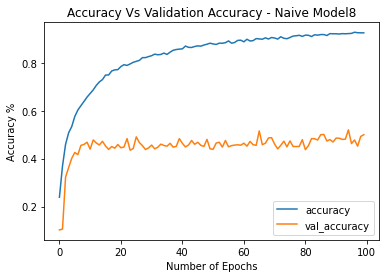

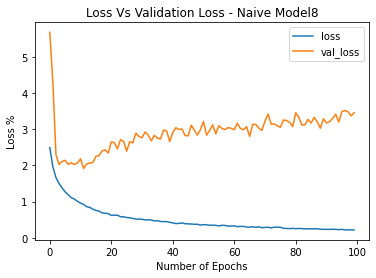

In [813]:
plot_losses(naive_model8, 'Naive Model8')

### Model Evalution

I tried many combinations to optimized the model. The model always hovered around the 50% validation accuracy mark. I did not include all attempts because that would make the notebook too long and there was no notable improvements.

|  Model Name (Best Weights) | Accuracy | Validation Accuracy | Epoch |
|-------------|----------|---------------------|-------|
| Naive Model |    91%   |         51%         |  34   | 
| Naive Model2 |    69%   |         41%         |  120   |
| Naive Model3 |    94%   |         54%         |  100   |
| Naive Model4 |    83%   |         50%         |  98   |
| Naive Model5 |    50%   |         28%         |  100   |
| Naive Model6 |    88%   |         40%         |  9   |
| Naive Model7 |    85%   |         47%         |  17   |
| Naive Model8 |    92%   |         52%         |  14   |
| Naive Model9 |    80%   |         46%         |  95   |

I will evalute `Naive Model3` since it was the best model among the list. 

**Performance - Frame of Reference**

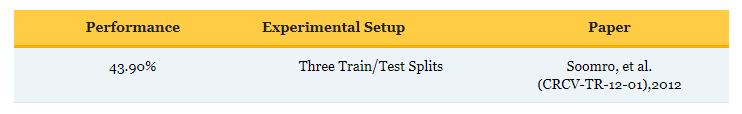

Originally, I was quite worried about the performance of my models. I discussed with an Educator and he told me that 50% validation accuracy is actually good considering there is 10 classes. If we were to randomly guess a class, there will be a 1 in 10 chance of being correct. In addition, the original dataset actually had an intial accuracy of [43.9%.](https://www.crcv.ucf.edu/data/UCF101.php) Computer Vision is a complex area and requires highly advance methods to solve. All in all, my best model performs better than randomly guessing and outperforms the initial accuracy of the original dataset.

**Potential Reason for Low Validation Accuracy** 

One reason for the low validation accuracy is perhaps there is one or two classes that the model severely fails to classify correctly. That can pull the overall accuracy down. Looking at the confusion matrix will prove whether our hypothesis holds true. 

**Confusion Matrix**

The confusion matrix for `Naive Model3` is significantly better than `Naive Model`. The true accuracy can found looking at the diagonal of the matrix. It correctly identify `Lunges`, `HorseRiding`, `HorseRace` very well. We can also see 2 classes that severely drags the overall accuracy down.
 

|  Class | True Accuracy %| 
|-------------|----------|
| BrushingTeeth | 2.7% |
| Nunchucks | 7.9% | 

`Naive Model3` seems to have great difficulty in correctly identifying `BrushingTeeth` and `Nunchucks`. The classes in which `BrushingTeeth` and `Nunchucks` are mistaken for is very odd and have no logical correlation (human-wise). Similary to the `Naive Model` confusion matrix, HorseRiding and Lunges tend be misclassifed for other classes. Due the time constraints, I will need to dive deeper after the bootcamp.

|  Brushing Teeth | Mistaken Accuracy %| 
|-------------|----------|
| Kayaking  | 33% |
| Lunges  | 63% | 

|  Nunchucks | Mistaken Accuracy %| 
|-------------|----------|
| JugglingBalls | 16% |
| Lunges | 25% |
| HorseRiding | 41% | 

In [1110]:
# find number of samples 
filesname = test_generator.filenames
nb_samples = len(filesname)

# Calculate the predictions
predict_probas = naive_model3.predict(test_generator, steps = np.ceil(nb_samples/32))

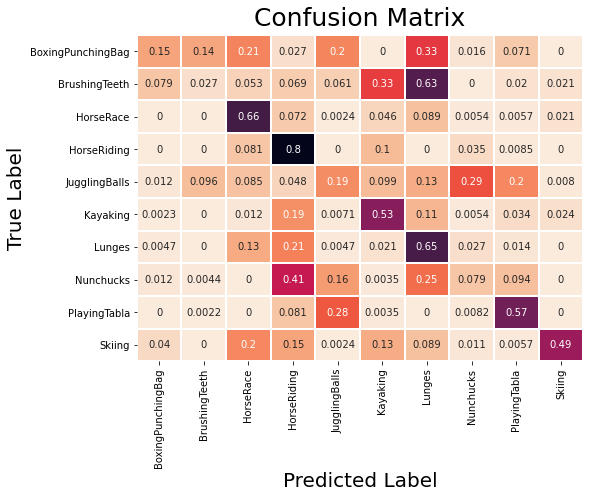

In [1111]:
# Convert probs to label encoding
y_predict = np.argmax(predict_probas, axis=1)

from sklearn.metrics import confusion_matrix
y_test_labels = np.argmax(y_test, axis=1)

# generate confusion matrix 
cf_matrix = confusion_matrix(y_test_labels, y_predict)
normalized_conf_mat = cf_matrix / cf_matrix.sum(axis=1)

# plot
plt.figure(figsize=(8,6))
sns.heatmap(normalized_conf_mat,
            annot=True,
            cbar=False,
            xticklabels = category_names,
            yticklabels = category_names,
            cmap="rocket_r",
            linewidths=1)

plt.title('Confusion Matrix', size = 25, y = 1.01)
plt.xlabel('Predicted Label', size = 20)
plt.ylabel('True Label', size = 20)
plt.show()

### Future Directions 

I plan to continue refining this project even after the Bootcamp. The most immediate action is identifying why some classes are being misclassifed. I really want to dive deeping on that exploration. Next, I want to experiment with Transfer Learning Models: VGG-16, ResNet50, Inceptionv3, and EfficientNet. I hope that using Transfer Learning Models may improve the validation accuracy.  Another method I want to test out is using Recurrent Neural Networks (RNN). Since we decided to break the videos into frames, RNN should shine since the videos follows a set sequence. 

I want to upload this project to Git Pages. It really important for me to create an online presence. Creating an online portfolio is a step in the right direction. Finally, I want deploy the model. I want to be able to upload a video to an API and return a classification result. Currently, I am thinking on using Flask or Streamlit for the framework. 

### Conclusion

The capstone project was challenging, yet an rewarding experience. I did encounter many hurdles but I learned alot along the way. Those hurdles taught me how to use be comfortable AWS, Hadoop, SageMaker, and Google Colab. There were times when I wanted to quit but with the encouragement and support from the Educators, I managed to perserve. The Educators coached me how to approach difficult problems but most importantly how to reframe my mindset. 

I am happy with my progress but there is still alot more to do and learn. During these past few weeks, I was able perform EDA and preprocessing on my data. I feel confident in preprocessing image data and it was a very enjoyable experience. I also liked researching and building specialize functions. In addition, I able pass my data into a 2D Convolutional Neural Network. It took alot of work to reach the Modelling Stage. With my own architecture, my best model was `Naive Model3`. 

|  Model Name (Best Weights) | Accuracy | Validation Accuracy | Epoch |
|-------------|----------|---------------------|-------|
| Naive Model3 |    94%   |         54%         |  100   |

I am especially proud of my final confusion matrix. Compared to the `Naive Model`'s confusion matrix, this one scored significantly better. We were able to identify 2 classes that severely dragging down the overall accuracy. `Naive Model3` was also very confident in identify certain classes. 

The goal/inspiration of the capstone project was teach myself computer vision. I developed a foundational understanding on neural networks and image classification. Neural Networks are black box models so I can never truly explain how it works. However, I want to continue learning about computer vision. This capstone project was a excellent stepping stone. 

The Data Science Bootcamp has been an incredible chapter in my life. The path in becoming a Data Scientist has become much more clearer but I still have alot of work ahead. I want to thank all the Educators for they everlasting support and love! I will make you proud! 